In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import scipy
import pandas as pd
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from matplotlib.figure import Figure
import package_outlier as po
import math
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler, StandardScaler
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from scipy.stats import pearsonr
import itertools
from sklearn.metrics import roc_auc_score, r2_score


### Volume Features

In [2]:
csv_path = os.getcwd()
csv_path

'/Users/saurabh/Desktop/HeartProjects/Exhalted/Params/Code_EXH'

In [3]:
vol_df = pd.read_csv('vol.csv')
vol_df.drop(columns='Unnamed: 0',inplace=True);
vol_df.head()

,patient_id,lvmc_std,lvmc_snr,lvmc_vol_es,lvmc_vol_ed,lvmc_vol_max,lvmc_vol_min,lvmc_vol_es_equal_max,lvmc_vol_max_minus_min,lv_std,lv_snr,lv_vol_es,lv_vol_ed,stroke_volume,ejection_fraction
0,100B,2250.174975,14.478556,122988.1875,139436.2500,148709.4375,118114.6875,0,0.205735,2168.140010,20.616114,164954.4375,196361.4375,31407.0000,0.159945
1,101B,3389.251079,10.381979,136187.2500,123462.0000,136187.2500,96996.1875,1,0.287773,9517.657049,2.837491,39867.9375,133344.3750,93476.4375,0.701015
2,103,3343.955006,14.820243,175513.6875,144242.0625,175513.6875,144242.0625,1,0.178172,10586.318292,4.654657,104983.3125,203333.2500,98349.9375,0.483688
3,105B,2464.666301,20.048423,156019.6875,153582.9375,176055.1875,148777.1250,0,0.154940,10604.243561,5.340548,123597.3750,226617.7500,103020.3750,0.454600
4,109,2522.159368,18.556770,111413.6250,126507.9375,135239.6250,111413.6250,0,0.176176,15817.902632,2.284888,42440.0625,153447.5625,111007.5000,0.723423


In [4]:
vol_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lvmc_std,57.0,1780.388646,965.513941,628.804706,1153.427697,1576.147548,2147.494534,5227.582422
lvmc_snr,57.0,23.673666,9.338710,6.836636,16.490328,22.998410,29.353887,51.752073
lvmc_vol_es,57.0,119445.798885,34100.139328,66739.875000,99432.937500,111481.312500,136187.250000,245279.123421
lvmc_vol_ed,57.0,116725.553853,26379.545589,65995.312500,101531.250000,112293.562500,131003.510365,200697.419636
lvmc_vol_max,57.0,127558.325442,32738.120539,71816.437500,109586.062500,122446.687500,143159.062500,249944.650562
lvmc_vol_min,57.0,108747.613617,27844.554100,59294.250000,91613.147363,106018.453125,128538.562500,200697.419636
lvmc_vol_es_equal_max,57.0,0.192982,0.398147,0.000000,0.000000,0.000000,0.000000,1.000000
lvmc_vol_max_minus_min,57.0,0.146202,0.055944,0.051396,0.107206,0.135528,0.180286,0.319470
lv_std,57.0,8723.386003,3067.369561,1293.227392,7026.437692,9064.454540,10604.243561,15817.902632
lv_snr,57.0,4.626109,3.411217,2.119069,3.227912,3.573549,4.431670,20.616114


In [5]:
vol_columns = vol_df.columns
numerical_columns = vol_columns.drop(['patient_id','lvmc_vol_es_equal_max']).values

In [6]:
vol_df.shape

(57, 15)

In [7]:
vol_df_scaled = vol_df.copy(deep=True)
vol_df_scaled[numerical_columns] = scaler.fit_transform(vol_df[numerical_columns])

#### Outlier analysis

Let's look at the outliers. The purpose of doing outlier analysis is to go back and check the raw images and do appropriate corrections on the segmentations if required. Low ejection fraction cases can be excluded from further analysis since it is a known cause of dyspnea. 

In [8]:
def outlier_func(df, numerical_columns, num_ouliers_min):
    '''
    Finds features with outliers
    '''
    outlier_features = []
    for feature in numerical_columns:
        outliers = po.ModifiedZscoreOutlier(df[feature].values)
        num_outliers = len(outliers)
        if num_outliers > num_ouliers_min:
            outlier_features.append(feature)
    return outlier_features

In [9]:
outlier_features = outlier_func(vol_df, numerical_columns, 3)
outlier_features

['lv_snr', 'ejection_fraction']

<AxesSubplot:>

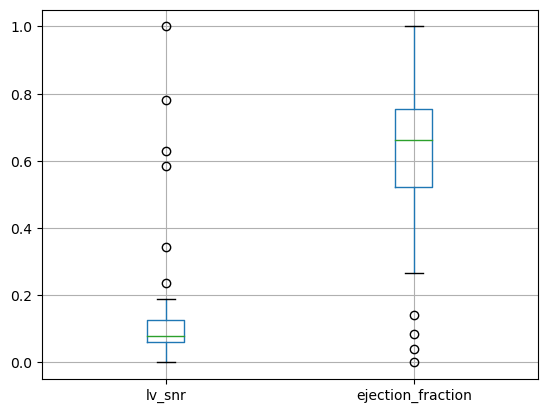

In [10]:
vol_df_scaled.boxplot(column = outlier_features[:])

In [11]:
feature = 'ejection_fraction'
outliers = po.ModifiedZscoreOutlier(vol_df[feature].values)
num_outliers = len(outliers)
print('number of outliers = ',num_outliers)

number of outliers =  4


In [12]:
vol_df.sort_values(by=[feature],ascending=True).head()

,patient_id,lvmc_std,lvmc_snr,lvmc_vol_es,lvmc_vol_ed,lvmc_vol_max,lvmc_vol_min,lvmc_vol_es_equal_max,lvmc_vol_max_minus_min,lv_std,lv_snr,lv_vol_es,lv_vol_ed,stroke_volume,ejection_fraction
0,100B,2250.174975,14.478556,122988.187500,139436.250000,148709.437500,118114.687500,0,0.205735,2168.140010,20.616114,164954.437500,196361.437500,31407.000000,0.159945
50,188,1153.427697,51.752073,138101.296538,131003.510365,138101.296538,131003.510365,1,0.051396,5913.262444,12.932917,148442.441956,182004.159358,33561.717402,0.184401
7,114,1034.658434,17.811026,85760.062500,100583.625000,100583.625000,82308.000000,0,0.181696,1293.227392,16.560371,92190.375000,117302.437500,25112.062500,0.214080
10,123,632.677214,35.794174,104794.921875,103072.265625,112374.609375,99684.375000,0,0.112928,1969.364777,13.761918,102096.093750,136032.421875,33936.328125,0.249472
8,119,1790.748163,21.044772,137337.937500,135984.187500,155748.937500,133547.437500,0,0.142547,3033.372628,8.487487,78179.062500,116693.250000,38514.187500,0.330046


In [13]:
vol_df[vol_df[feature] < 0.4].sort_values(by=[feature],ascending=True)

,patient_id,lvmc_std,lvmc_snr,lvmc_vol_es,lvmc_vol_ed,lvmc_vol_max,lvmc_vol_min,lvmc_vol_es_equal_max,lvmc_vol_max_minus_min,lv_std,lv_snr,lv_vol_es,lv_vol_ed,stroke_volume,ejection_fraction
0,100B,2250.174975,14.478556,122988.187500,139436.250000,148709.437500,118114.687500,0,0.205735,2168.140010,20.616114,164954.437500,196361.437500,31407.000000,0.159945
50,188,1153.427697,51.752073,138101.296538,131003.510365,138101.296538,131003.510365,1,0.051396,5913.262444,12.932917,148442.441956,182004.159358,33561.717402,0.184401
7,114,1034.658434,17.811026,85760.062500,100583.625000,100583.625000,82308.000000,0,0.181696,1293.227392,16.560371,92190.375000,117302.437500,25112.062500,0.214080
10,123,632.677214,35.794174,104794.921875,103072.265625,112374.609375,99684.375000,0,0.112928,1969.364777,13.761918,102096.093750,136032.421875,33936.328125,0.249472
8,119,1790.748163,21.044772,137337.937500,135984.187500,155748.937500,133547.437500,0,0.142547,3033.372628,8.487487,78179.062500,116693.250000,38514.187500,0.330046
5,111,1603.417244,15.159323,117975.000000,121875.000000,130275.000000,106575.000000,0,0.181923,3565.792521,6.507337,88800.000000,142875.000000,54075.000000,0.378478


In [14]:
low_lv_ef = vol_df[vol_df['ejection_fraction'] < 0.4].patient_id.values
low_lv_ef

array(['100B', '111', '114', '119', '123', '188'], dtype=object)

In [15]:
vol_df = vol_df[~vol_df['patient_id'].isin(low_lv_ef)]
vol_df.shape

(51, 15)

In [16]:
cpet_file = csv_path + '/ExerciseMRIEvaluatio_DATA_LABELS_2021-03-16_1304.xlsx'
cpet_data = pd.read_excel(cpet_file)
cpet_data.dropna(subset=['VO2 (MAX):'],inplace=True)
cpet_data.dropna(subset=['VO2 %Predicted '],inplace=True)
cpet_data.shape

(67, 662)

In [17]:
cutoff_pkvo2 = 79.7
cpet_data.loc[cpet_data['VO2 %Predicted '] < cutoff_pkvo2, 'dyspnea'] = int(1)
cpet_data.loc[cpet_data['VO2 %Predicted '] >= cutoff_pkvo2, 'dyspnea'] = int(0)

In [18]:
Counter(cpet_data['dyspnea'])

Counter({1.0: 42, 0.0: 25})

#### U Test with volumetric features

In [19]:
def u_test_func(df, numerical_columns):
    '''
    Performs Mann Whitney u test
    '''
    num_rows = df.shape[0]
    u_test_features = []

    for feature in numerical_columns:
        dyspnea_arr = []
        normal_arr = []

        for n in range(num_rows):
            arr = df.iloc[n][feature]
            pid = df.iloc[n]['patient_id']
            num_pid = int(pid[0:3])
            cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
            condition = cpet_record['dyspnea']
            if condition.values[0] == 1.:
                dyspnea_arr.append(arr)
            else:
                normal_arr.append(arr)
        res = scipy.stats.mannwhitneyu(dyspnea_arr,normal_arr)
        u_test_features.append((feature,res.pvalue))    
    return u_test_features, dyspnea_arr, normal_arr

In [20]:
u_test_vol_features, _, _ = u_test_func(vol_df, numerical_columns)

In [21]:
u_test_vol_features

[('lvmc_std', 0.349429650644948),
 ('lvmc_snr', 0.9923034439407639),
 ('lvmc_vol_es', 0.19949422755294488),
 ('lvmc_vol_ed', 0.047984893871884),
 ('lvmc_vol_max', 0.11811272662155761),
 ('lvmc_vol_min', 0.10303656989963925),
 ('lvmc_vol_max_minus_min', 0.6642261038198841),
 ('lv_std', 0.05490540125688835),
 ('lv_snr', 0.8394684869626301),
 ('lv_vol_es', 0.28863412450117),
 ('lv_vol_ed', 0.10930369698520317),
 ('stroke_volume', 0.12040815825090957),
 ('ejection_fraction', 0.692473599299549)]

In [22]:
significant_feat = [ent for ent in u_test_vol_features if ent[1] < 0.055]
print('significant features: (feature name, p-value)\n', [(ent[0], round(ent[1],4)) for ent in significant_feat])

significant features: (feature name, p-value)
 [('lvmc_vol_ed', 0.048), ('lv_std', 0.0549)]


In [23]:
important_features = []
important_features.extend([feat[0] for feat in significant_feat])
important_features

['lvmc_vol_ed', 'lv_std']

In [24]:
significant_features = [feat[0] for feat in significant_feat]
X = vol_df_scaled[significant_features].assign(const=1)
vif_values = [vif(X.values, i) for i in range(len(significant_features))]
vif_feat_vals = {significant_features[ind]: vals for ind,vals in enumerate(vif_values)}
vif_feat_vals = sorted(vif_feat_vals.items(), key = lambda item: item[1], reverse = True)
print('VIF values: (feature, value)\n')
[print(ent[0], round(ent[1],3)) for ent in vif_feat_vals];

VIF values: (feature, value)

lvmc_vol_ed 1.089
lv_std 1.089


In [25]:
def box_plot_func(title1, title2, df, feature1, feature2, y1, y2):
    fig = Figure(figsize=(15,5))
    ax = fig.add_subplot(1,2,1)
    ax.set_title(title1,fontsize = 14)
    ax.set_xlabel('Measured PkVO$_{2}$ as percentage of predicted PkVO$_{2}$',fontsize=14)
    u_test_vals, dyspnea_arr, normal_arr = u_test_func(df, [feature1])
    ax.boxplot([dyspnea_arr, normal_arr])
    ax.set_xticklabels(labels=['Below 80%','Above 80%'],fontsize=14)
    ax.text(1.2,y1,f'p = {round(u_test_vals[0][1],2)}',fontsize=14)

    ax = fig.add_subplot(1,2,2)
    ax.set_title(title2,fontsize = 14)
    ax.set_xlabel('Measured PkVO$_{2}$ as percentage of predicted PkVO$_{2}$',fontsize=14)
    u_test_vals, dyspnea_arr, normal_arr = u_test_func(df, [feature2])
    ax.boxplot([dyspnea_arr, normal_arr])
    print(len(dyspnea_arr), len(normal_arr))
    ax.set_xticklabels(labels=['Below 80%','Above 80%'],fontsize=14)
    ax.text(1.2,y2,f'p = {round(u_test_vals[0][1],2)}',fontsize=14)

    return fig

31 20


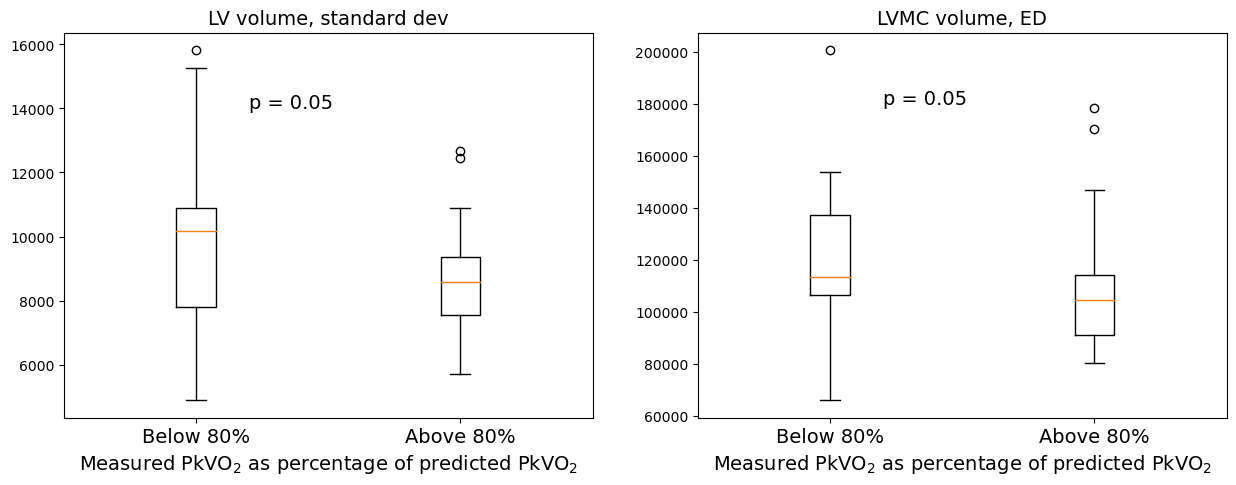

In [26]:
box_plot_func('LV volume, standard dev', 'LVMC volume, ED',  vol_df, 'lv_std', 'lvmc_vol_ed', 14000, 180000)

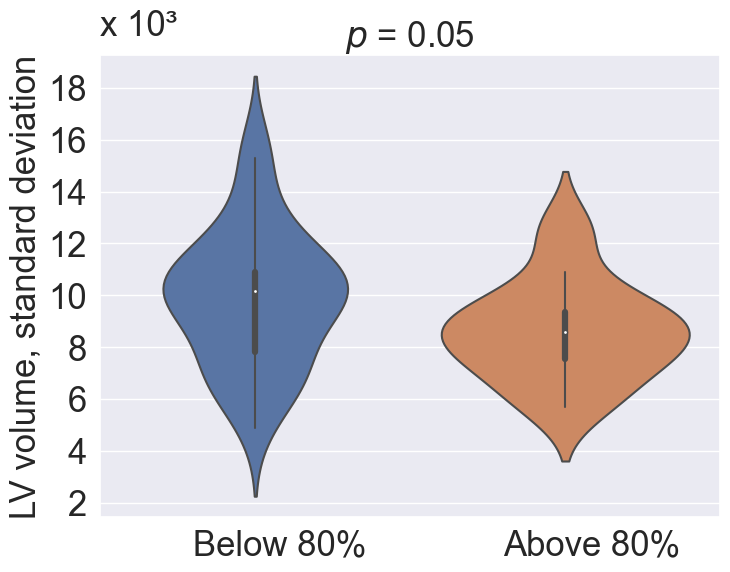

In [28]:
fontsize=25
u_test_vals, dyspnea_arr, normal_arr = u_test_func(vol_df, ['lv_std'])
sns.set(rc={'figure.figsize':(8,6)})
s = sns.violinplot(data=[[ent/1E3 for ent in dyspnea_arr], [ent/1E3 for ent in normal_arr]])
plt.title('$p$ = 0.05',fontsize=fontsize)
plt.ylabel('LV volume, standard deviation',fontsize=fontsize)
plt.text(-0.5,20,'x 10\u00b3',fontsize=fontsize)
plt.text(-0.2,0,'Below 80%',fontsize=fontsize)
plt.text(0.8,0,'Above 80%',fontsize=fontsize)
plt.yticks(fontsize=fontsize)
s.set(xticks=[])
plt.xticks(fontsize=fontsize)
plt.savefig('lv_std_violin.png')
plt.show()

### Calculating sphericity index (Nakamori et. al.)

In [62]:
sphericity_index_df = pd.read_csv('sphericity_index.csv')
sphericity_index_df.drop(columns='Unnamed: 0',inplace=True);
sphericity_index_df.head()

,patient_id,sphericity_index
0,100B,0.326234
1,101B,0.429673
2,103,0.655197
3,105B,0.489195
4,109,0.331244


In [63]:
sphericity_index_df.describe()

,sphericity_index
count,57.000000
mean,0.405743
std,0.115328
min,0.209479
25%,0.331244
50%,0.392888
75%,0.470241
max,0.675724


In [64]:
sphericity_index_df = sphericity_index_df[~sphericity_index_df['patient_id'].isin(low_lv_ef)]
sphericity_index_df.shape

(51, 2)

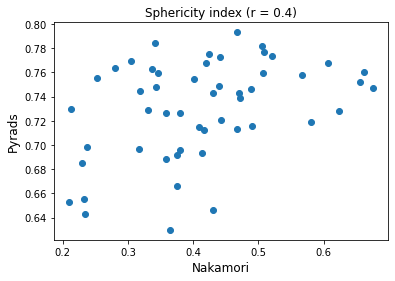

In [76]:
plt.scatter(sphericity_index_df['sphericity_index'], pyrads_3d_df['median_original_shape_Sphericity'])
plt.xlabel('Nakamori', fontsize=12)
plt.ylabel('Pyrads', fontsize=12)
plt.title('Sphericity index (r = 0.4)', fontsize=12);

In [67]:
sphericity_index_df.patient_id.values

array(['101B', '103', '105B', '109', '113B', '121', '124', '126', '129',
       '130', '132', '133', '134', '135', '136A', '141', '142', '143',
       '146', '147', '149', '150', '151', '153', '154', '157', '158',
       '159', '160', '161', '162', '164', '167', '168', '169', '170',
       '174', '175', '179', '180', '181', '183', '184', '185', '187',
       '190', '191', '194', '199', '200', '201'], dtype=object)

In [70]:
pyrads_3d_df.patient_id.values

array(['101B', '103', '105B', '109', '113B', '121', '124', '126', '129',
       '130', '132', '133', '134', '135', '136A', '141', '142', '143',
       '146', '147', '149', '150', '151', '153', '154', '157', '158',
       '159', '160', '161', '162', '164', '167', '168', '169', '170',
       '174', '175', '179', '180', '181', '183', '184', '185', '187',
       '190', '191', '194', '199', '200', '201'], dtype=object)

In [66]:
pearson_val = pearsonr(sphericity_index_df['sphericity_index'], pyrads_3d_df['median_original_shape_Sphericity'])
pearson_val

(0.4053222323875756, 0.0031715597174176925)

In [53]:
u_test_sph_ind_features, _, _ = u_test_func(sphericity_index_df, ['sphericity_index'])
u_test_sph_ind_features

[('sphericity_index', 0.21220704174389726)]

32 19


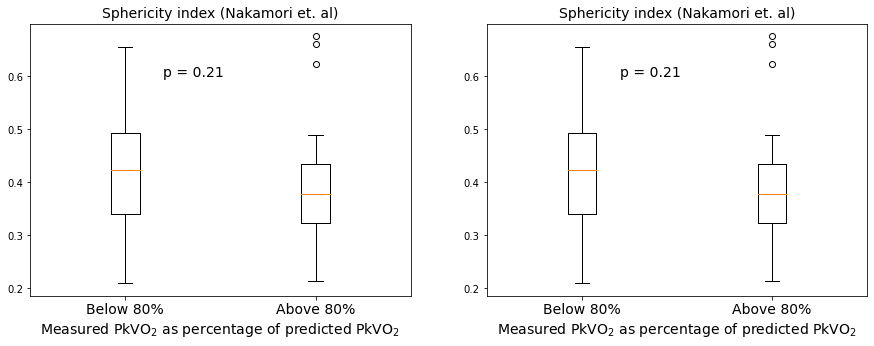

In [54]:
box_plot_func('Sphericity index (Nakamori et. al)', 'Sphericity index (Nakamori et. al)',  sphericity_index_df, 'sphericity_index', 'sphericity_index', 0.6, 0.6)

### Noise addition

In [30]:
expanded_vol_df = pd.read_csv('expanded_vol.csv')
expanded_vol_df.drop(columns='Unnamed: 0',inplace=True);
expanded_vol_df.head()

,patient_id,lvmc_std,lvmc_snr,lvmc_vol_es,lvmc_vol_ed,lvmc_vol_max,lvmc_vol_min,lvmc_vol_es_equal_max,lvmc_vol_max_minus_min,lv_std,lv_snr,lv_vol_es,lv_vol_ed,stroke_volume,ejection_fraction
0,100B,3919.588503,12.837063,187968.1875,248954.6250,248954.6250,182688.5625,0,0.266177,3200.611985,16.497972,193857.0000,252542.0625,58685.0625,0.232377
1,101B,4402.908766,11.327742,173821.5000,183297.7500,183297.7500,134021.2500,0,0.268833,10906.169101,3.027145,52119.3750,159336.3750,107217.0000,0.672897
2,103,2068.519368,33.957407,234131.0625,215787.7500,234131.0625,213757.1250,1,0.087019,11561.745445,5.026745,128132.4375,235417.1250,107284.6875,0.455722
3,105B,2734.512171,26.437718,216396.9375,233589.5625,244419.5625,213486.3750,0,0.126558,11742.138494,5.671204,148371.0000,262424.4375,114053.4375,0.434614
4,109,6633.753559,10.059562,146881.8750,194195.4375,200761.1250,146881.8750,0,0.268375,18152.306539,2.441849,55368.3750,182959.3125,127590.9375,0.697373


In [137]:
feature='ejection_fraction'
expanded_vol_df[expanded_vol_df[feature] < 0.4].sort_values(by=[feature],ascending=True)

,patient_id,lvmc_std,lvmc_snr,lvmc_vol_es,lvmc_vol_ed,lvmc_vol_max,lvmc_vol_min,lvmc_vol_es_equal_max,lvmc_vol_max_minus_min,lv_std,lv_snr,lv_vol_es,lv_vol_ed,stroke_volume,ejection_fraction
50,188,622.544876,138.322445,194131.502621,194366.528654,194366.528654,191217.179822,0,0.016203,6414.012939,13.730393,172415.097243,208797.127032,36382.029789,0.174246
7,114,1443.881497,19.926885,130907.625000,155275.125000,155275.125000,128335.500000,0,0.173496,1527.918224,16.988700,111752.062500,141263.812500,29511.750000,0.208912
10,123,744.120906,46.472478,156130.078125,159116.015625,167671.875000,151880.859375,0,0.094178,2115.842107,15.269455,124146.093750,160666.406250,36520.312500,0.227305
0,100B,3919.588503,12.837063,187968.187500,248954.625000,248954.625000,182688.562500,0,0.266177,3200.611985,16.497972,193857.000000,252542.062500,58685.062500,0.232377
8,119,2426.052506,21.565826,187155.937500,195887.625000,212132.625000,183365.437500,0,0.135609,3392.593815,9.291531,97876.125000,140993.062500,43116.937500,0.305809
5,111,2700.814809,13.474506,170550.000000,189075.000000,196200.000000,161250.000000,0,0.178135,4161.856680,6.799212,109650.000000,172200.000000,62550.000000,0.363240
15,132,918.028450,55.756087,187765.125000,187155.937500,187765.125000,177612.000000,1,0.054074,7222.502642,6.077461,114053.437500,184719.187500,70665.750000,0.382558
37,167,1374.106615,31.124876,137202.562500,145189.687500,146408.062500,131719.875000,0,0.100324,6317.423475,5.840483,92393.437500,153109.125000,60715.687500,0.396552


In [31]:
low_lv_ef = np.append(low_lv_ef,'188')
expanded_vol_df = expanded_vol_df[~expanded_vol_df['patient_id'].isin(low_lv_ef)]
expanded_vol_df.shape

(51, 15)

In [140]:
expanded_vol_columns = expanded_vol_df.columns.values
numerical_columns = vol_columns.drop(['patient_id','lvmc_vol_es_equal_max']).values

In [141]:
u_test_expanded_vol_features, _, _ = u_test_func(expanded_vol_df, numerical_columns)

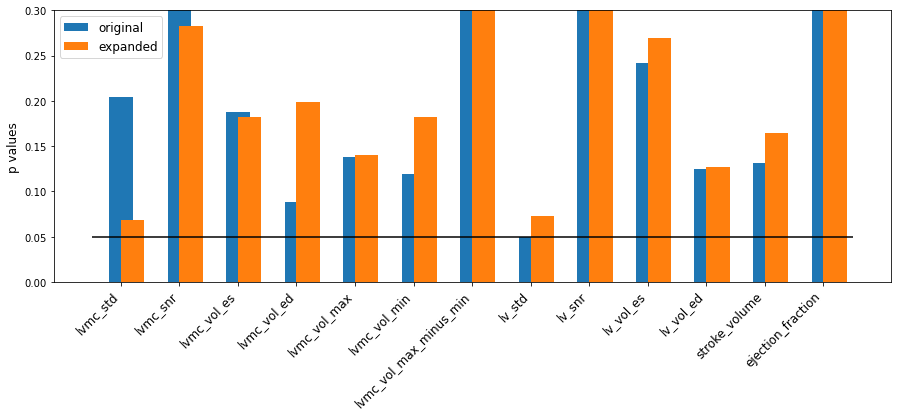

In [152]:
plt.figure(figsize=(15,5))
x = [feature[0] for feature in u_test_vol_features]
y1 = [feature[1] for feature in u_test_vol_features]
y2 = [feature[1] for feature in u_test_expanded_vol_features]
plt.bar(x,y1,label='original',width=0.4)
plt.bar(x,y2,label='expanded',width=0.4, align='edge')
plt.xticks(x, rotation=45, ha="right", fontsize=12)
#plt.yscale('log')
plt.ylim(0,0.3)
plt.hlines(0.05, -0.5,12.5,colors='black')
plt.ylabel('p values', fontsize=12)
plt.legend(fontsize=12);

#### Correlation analysis

In [35]:
pids = vol_df.patient_id.values
pkvo2_vals = []
petco2_vals = []
for pid in pids:
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    pkvo2_vals.append(cpet_record['VO2 (MAX):'].values[0])
    petco2_vals.append(cpet_record['PetCO2.2'].values[0])    

In [36]:
vol_df['pkvo2'] = pkvo2_vals
vol_df['petco2'] = petco2_vals

In [37]:
response = pkvo2_vals
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(vol_df[predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0]**2,3), "{:.2e}".format(pearson_val[1])))
print('significant features: \n(feature name, R^2, p-value)\n')
significant_feat = [ent for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.1]
significant_feat

significant features: 
(feature name, R^2, p-value)



[('lvmc_vol_min', 0.279, '6.77e-05'),
 ('lv_vol_es', 0.263, '1.20e-04'),
 ('lvmc_vol_ed', 0.251, '1.80e-04'),
 ('lv_vol_ed', 0.229, '3.76e-04'),
 ('lvmc_vol_es', 0.224, '4.57e-04'),
 ('lvmc_vol_max', 0.21, '7.10e-04'),
 ('lv_snr', 0.134, '8.34e-03'),
 ('ejection_fraction', 0.11, '1.76e-02')]

In [38]:
significant_features = [feat[0] for feat in significant_feat][5:] + [[feat[0] for feat in significant_feat][3]]
X = vol_df_scaled[significant_features].assign(const=1)
vif_values = [vif(X.values, i) for i in range(len(significant_features))]
vif_feat_vals = {significant_features[ind]: vals for ind,vals in enumerate(vif_values)}
vif_feat_vals = sorted(vif_feat_vals.items(), key = lambda item: item[1], reverse = True)
print('VIF values: (feature, value)\n')
[print(ent[0], round(ent[1],3)) for ent in vif_feat_vals];

VIF values: (feature, value)

ejection_fraction 4.521
lv_snr 4.365
lvmc_vol_max 1.847
lv_vol_ed 1.825


In [39]:
important_features.extend(significant_features)
important_features = list(set(important_features))
important_features

['lv_snr',
 'lvmc_vol_ed',
 'lv_std',
 'ejection_fraction',
 'lv_vol_ed',
 'lvmc_vol_max']

In [40]:
null_petco2_pids = vol_df[vol_df['petco2'].isna()].patient_id.values
print('patient ids with missing Pet CO2 \n', null_petco2_pids)

patient ids with missing Pet CO2 
 ['135']


In [41]:
response = vol_df[~vol_df['patient_id'].isin(null_petco2_pids)]['petco2']
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(vol_df[~vol_df['patient_id'].isin(null_petco2_pids)][predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],6)))
print('significant features: \n(feature name, R^2, p-value)\n')
significant_feat = [ent for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.1]
significant_feat

significant features: 
(feature name, R^2, p-value)



[('lv_vol_ed', 0.315, 2.2e-05),
 ('stroke_volume', 0.233, 0.000379),
 ('lv_vol_es', 0.184, 0.001899),
 ('lvmc_vol_max', 0.15, 0.005424),
 ('lvmc_vol_es', 0.146, 0.006175),
 ('lvmc_vol_min', 0.141, 0.007301),
 ('lvmc_vol_ed', 0.127, 0.01117)]

In [42]:
significant_features = [feat[0] for feat in significant_feat][5:]
X = vol_df_scaled[significant_features].assign(const=1)
vif_values = [vif(X.values, i) for i in range(len(significant_features))]
vif_feat_vals = {significant_features[ind]: vals for ind,vals in enumerate(vif_values)}
vif_feat_vals = sorted(vif_feat_vals.items(), key = lambda item: item[1], reverse = True)
print('VIF values: (feature, value)\n')
[print(ent[0], round(ent[1],3)) for ent in vif_feat_vals];

VIF values: (feature, value)

lvmc_vol_min 9.917
lvmc_vol_ed 9.917


In [43]:
important_features.extend(['lv_vol_ed', 'stroke_volume', 'lvmc_vol_max'])

### Pyradiomics 3d features

In [29]:
pyrads_3d_df = pd.read_csv('pyrads_3d.csv')
pyrads_3d_df.drop(columns='Unnamed: 0',inplace=True);
pyrads_3d_df.tail()

,min_original_shape_Elongation,min_original_shape_Flatness,min_original_shape_LeastAxisLength,min_original_shape_MajorAxisLength,min_original_shape_Maximum2DDiameterColumn,min_original_shape_Maximum2DDiameterRow,min_original_shape_Maximum2DDiameterSlice,min_original_shape_Maximum3DDiameter,min_original_shape_MeshVolume,min_original_shape_MinorAxisLength,...,ed_val_original_shape_Maximum2DDiameterSlice,ed_val_original_shape_Maximum3DDiameter,ed_val_original_shape_MeshVolume,ed_val_original_shape_MinorAxisLength,ed_val_original_shape_Sphericity,ed_val_original_shape_SurfaceArea,ed_val_original_shape_SurfaceVolumeRatio,ed_val_original_shape_VoxelVolume,ed_val_original_shape_AxisRatios,patient_id
52,0.405778,0.387128,34.085171,79.586113,85.955235,93.882268,42.085298,94.165008,57676.083911,35.819611,...,59.041115,120.465067,150684.231441,49.004307,0.704417,19440.135711,0.129012,151888.828014,2.087969,191
53,0.523913,0.490166,38.273509,66.514456,78.656072,77.147597,48.961878,80.087262,65247.143647,39.874683,...,65.522074,95.397728,156462.705306,56.101760,0.781266,17973.208384,0.114872,157608.457213,1.477856,194
54,0.464509,0.440370,38.760831,76.505190,87.791303,87.791303,50.055578,89.849016,79827.368753,41.451489,...,63.671740,115.104661,184157.062555,52.830766,0.763185,20510.673146,0.111376,185185.538802,1.904188,199
55,0.402376,0.373181,36.493419,88.393961,91.570792,88.919595,45.096467,93.046752,68502.499455,37.164443,...,67.840914,119.300873,235389.800936,59.465704,0.713337,25845.288920,0.109798,236665.842547,1.870038,200
56,0.337322,0.315769,32.697454,101.394964,110.193083,110.974380,45.096467,111.303277,68703.542469,35.056133,...,63.906164,127.374804,188254.352416,54.811827,0.670840,23678.918509,0.125782,189532.055539,1.982617,201


In [30]:
pyrads_3d_df.describe().T

,count,mean,std,min,25%,50%,75%,max
min_original_shape_Elongation,57.0,0.487112,0.063486,0.337322,0.453733,0.495134,0.535261,0.599829
min_original_shape_Flatness,57.0,0.435952,0.056442,0.315769,0.399395,0.440370,0.489693,0.533986
min_original_shape_LeastAxisLength,57.0,34.939911,5.279522,23.784889,31.718557,34.641259,38.210702,49.817307
min_original_shape_MajorAxisLength,57.0,74.822626,10.605917,51.937018,66.514456,73.629509,82.730094,101.394964
min_original_shape_Maximum2DDiameterColumn,57.0,81.453770,10.442657,62.936476,75.815978,79.306762,88.131216,110.193083
...,...,...,...,...,...,...,...,...
ed_val_original_shape_Sphericity,57.0,0.748044,0.034444,0.663028,0.726819,0.753739,0.773154,0.806397
ed_val_original_shape_SurfaceArea,57.0,18135.284948,3029.364175,12633.063217,15921.523883,17507.641426,20510.673146,25845.288920
ed_val_original_shape_SurfaceVolumeRatio,57.0,0.123576,0.011447,0.105672,0.115091,0.122124,0.129177,0.157789
ed_val_original_shape_VoxelVolume,57.0,150759.230629,34819.526784,81428.062500,128132.437500,146340.375000,175919.812500,236665.842547


In [31]:
pyrads_3d_df = pyrads_3d_df[~pyrads_3d_df['patient_id'].isin(low_lv_ef)]
pyrads_3d_df.shape

(51, 121)

In [32]:
pyrads_3d_columns = pyrads_3d_df.columns
numerical_columns = pyrads_3d_columns.drop(['patient_id']).values

In [33]:
pyrads_3d_columns.values

array(['min_original_shape_Elongation', 'min_original_shape_Flatness',
       'min_original_shape_LeastAxisLength',
       'min_original_shape_MajorAxisLength',
       'min_original_shape_Maximum2DDiameterColumn',
       'min_original_shape_Maximum2DDiameterRow',
       'min_original_shape_Maximum2DDiameterSlice',
       'min_original_shape_Maximum3DDiameter',
       'min_original_shape_MeshVolume',
       'min_original_shape_MinorAxisLength',
       'min_original_shape_Sphericity', 'min_original_shape_SurfaceArea',
       'min_original_shape_SurfaceVolumeRatio',
       'min_original_shape_VoxelVolume', 'min_original_shape_AxisRatios',
       'max_original_shape_Elongation', 'max_original_shape_Flatness',
       'max_original_shape_LeastAxisLength',
       'max_original_shape_MajorAxisLength',
       'max_original_shape_Maximum2DDiameterColumn',
       'max_original_shape_Maximum2DDiameterRow',
       'max_original_shape_Maximum2DDiameterSlice',
       'max_original_shape_Maximum3DDiam

0.9100189482261005

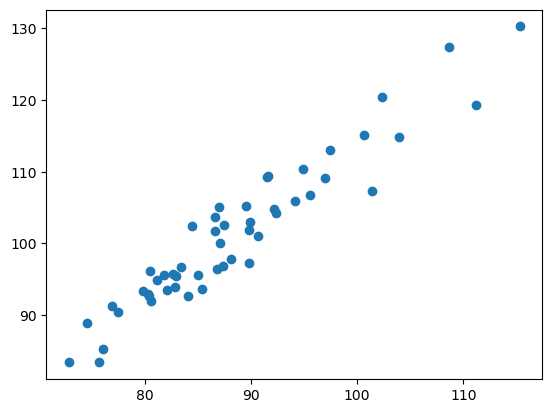

In [31]:
x = pyrads_3d_df['ed_val_original_shape_MajorAxisLength']
y = pyrads_3d_df['ed_val_original_shape_Maximum3DDiameter']
plt.scatter(x, y)
pearsonr(x, y)[0]**2

In [32]:
outlier_features = outlier_func(pyrads_3d_df, numerical_columns, 4)
outlier_features

['snr_original_shape_MajorAxisLength',
 'snr_original_shape_Maximum2DDiameterRow',
 'snr_original_shape_Sphericity']

In [33]:
pyrads_3d_df_scaled = pyrads_3d_df.copy(deep=True)
pyrads_3d_df_scaled[numerical_columns] = scaler.fit_transform(pyrads_3d_df[numerical_columns])

<AxesSubplot:>

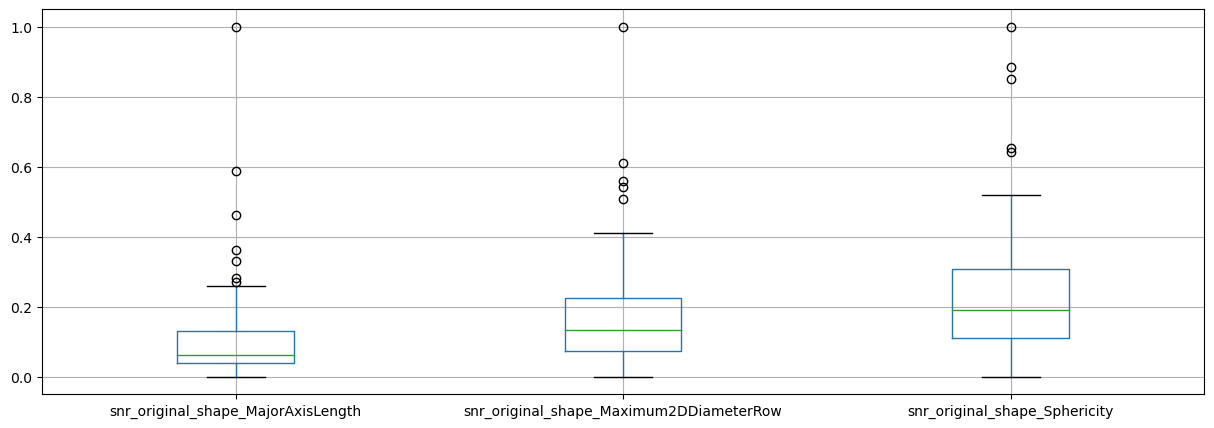

In [34]:
pyrads_3d_df_scaled.boxplot(column = outlier_features, figsize = (15,5))

In [35]:
feature='snr_original_shape_MajorAxisLength'
pyrads_3d_df.sort_values(by=[feature], ascending=False)[['patient_id',feature]].head()

,patient_id,snr_original_shape_MajorAxisLength
31,158,131.295835
15,132,80.157937
13,129,64.545269
22,143,52.175064
2,103,48.235075


In [36]:
u_test_pyrads_3d_features, _, _ = u_test_func(pyrads_3d_df, numerical_columns)

In [37]:
significant_feat = [ent for ent in u_test_pyrads_3d_features if ent[1] < 0.055]
print('significant features: (feature name, p-value)')
significant_feat = [(ent[0], round(ent[1],3)) for ent in sorted(significant_feat, key = lambda x: x[1])]
significant_feat

significant features: (feature name, p-value)


[('max_original_shape_SurfaceArea', 0.03),
 ('ed_val_original_shape_SurfaceArea', 0.036),
 ('mean_original_shape_SurfaceArea', 0.04),
 ('median_original_shape_Sphericity', 0.042),
 ('es_val_original_shape_Maximum2DDiameterSlice', 0.051),
 ('mean_original_shape_Sphericity', 0.053),
 ('min_original_shape_Maximum2DDiameterSlice', 0.055),
 ('max_original_shape_LeastAxisLength', 0.055),
 ('median_original_shape_SurfaceArea', 0.055),
 ('std_dev_original_shape_MeshVolume', 0.055),
 ('std_dev_original_shape_VoxelVolume', 0.055)]

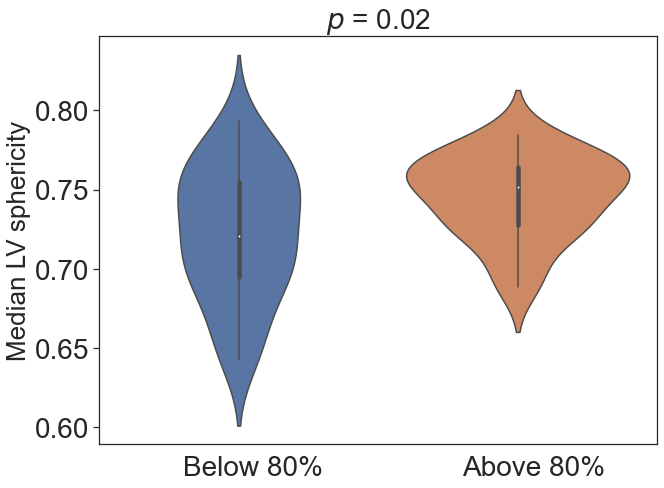

In [216]:
fontsize=28
u_test_vals, dyspnea_arr, normal_arr = u_test_func(pyrads_3d_df, ['median_original_shape_Sphericity'])
sns.set(rc={'figure.figsize':(10,7.5),'axes.facecolor':'white'}, style="ticks")
s = sns.violinplot(data=[dyspnea_arr, normal_arr])
plt.title('$p$ = 0.02',fontsize=fontsize)
plt.ylabel('Median LV sphericity',fontsize=fontsize-2)
plt.text(-0.2,0.57,'Below 80%',fontsize=fontsize)
plt.text(0.8,0.57,'Above 80%',fontsize=fontsize)
plt.yticks(fontsize=fontsize)
s.set(xticks=[])
plt.xticks(fontsize=fontsize)
plt.savefig('median_LV_spericity_violin.png')
plt.show()

In [54]:
significant_features = [feat[0] for feat in significant_feat][2:5] + [feat[0] for feat in significant_feat][8:9] + \
[feat[0] for feat in significant_feat][15:16]
X = pyrads_3d_df_scaled[significant_features].assign(const=1)
vif_values = [vif(X.values, i) for i in range(len(significant_features))]
vif_feat_vals = {significant_features[ind]: vals for ind,vals in enumerate(vif_values)}
vif_feat_vals = sorted(vif_feat_vals.items(), key = lambda item: item[1], reverse = True)
print('VIF values: (feature, value)\n')
[print(ent[0], round(ent[1],3)) for ent in vif_feat_vals];

VIF values: (feature, value)

mean_original_shape_SurfaceArea 37.588
median_original_shape_SurfaceArea 30.225
ed_val_original_shape_LeastAxisLength 5.524
es_val_original_shape_Maximum2DDiameterSlice 2.71
median_original_shape_Sphericity 1.321


In [38]:
important_features.extend([feat[0] for feat in significant_feat])
important_features = list(set(important_features))
important_features

['std_dev_original_shape_VoxelVolume',
 'median_original_shape_Sphericity',
 'ed_val_original_shape_SurfaceArea',
 'lvmc_vol_ed',
 'mean_original_shape_Sphericity',
 'es_val_original_shape_Maximum2DDiameterSlice',
 'lv_std',
 'std_dev_original_shape_MeshVolume',
 'min_original_shape_Maximum2DDiameterSlice',
 'max_original_shape_SurfaceArea',
 'mean_original_shape_SurfaceArea',
 'max_original_shape_LeastAxisLength',
 'median_original_shape_SurfaceArea']

In [39]:
pids = pyrads_3d_df.patient_id.values
pkvo2_vals = []
petco2_vals = []
for pid in pids:
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    pkvo2_vals.append(cpet_record['VO2 (MAX):'].values[0])
    petco2_vals.append(cpet_record['PetCO2.2'].values[0])  
    
pyrads_3d_df['pkvo2'] = pkvo2_vals
pyrads_3d_df['petco2'] = petco2_vals

In [40]:
response = pkvo2_vals
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(pyrads_3d_df[predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],6)))
[print(ent) for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.1];

('min_original_shape_VoxelVolume', 0.263, 0.00012)
('es_val_original_shape_VoxelVolume', 0.263, 0.00012)
('min_original_shape_MeshVolume', 0.262, 0.000122)
('es_val_original_shape_MeshVolume', 0.262, 0.000122)
('mean_original_shape_VoxelVolume', 0.251, 0.000184)
('mean_original_shape_MeshVolume', 0.25, 0.000185)
('median_original_shape_MeshVolume', 0.25, 0.000187)
('median_original_shape_VoxelVolume', 0.25, 0.000189)
('median_original_shape_SurfaceVolumeRatio', 0.248, 0.000199)
('mean_original_shape_SurfaceVolumeRatio', 0.246, 0.000213)
('min_original_shape_SurfaceArea', 0.241, 0.000255)
('es_val_original_shape_SurfaceArea', 0.238, 0.000286)
('max_original_shape_MeshVolume', 0.229, 0.000382)
('max_original_shape_VoxelVolume', 0.229, 0.000376)
('ed_val_original_shape_MeshVolume', 0.229, 0.000382)
('ed_val_original_shape_VoxelVolume', 0.229, 0.000376)
('median_original_shape_LeastAxisLength', 0.228, 0.000389)
('max_original_shape_SurfaceVolumeRatio', 0.225, 0.000441)
('es_val_original_sh

In [41]:
response = pkvo2_vals
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(pyrads_3d_df[predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0],3), round(pearson_val[1],6)))
[print(ent) for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=False) if ent[1] < 0.];

('median_original_shape_SurfaceVolumeRatio', -0.498, 0.000199)
('mean_original_shape_SurfaceVolumeRatio', -0.496, 0.000213)
('max_original_shape_SurfaceVolumeRatio', -0.474, 0.000441)
('es_val_original_shape_SurfaceVolumeRatio', -0.469, 0.000513)
('min_original_shape_SurfaceVolumeRatio', -0.45, 0.000927)
('ed_val_original_shape_SurfaceVolumeRatio', -0.45, 0.000909)
('std_dev_original_shape_SurfaceVolumeRatio', -0.404, 0.003306)
('std_dev_original_shape_Sphericity', -0.373, 0.007102)
('std_dev_original_shape_MajorAxisLength', -0.276, 0.050229)
('std_dev_original_shape_LeastAxisLength', -0.163, 0.253023)
('snr_original_shape_AxisRatios', -0.128, 0.369482)
('std_dev_original_shape_Maximum2DDiameterColumn', -0.122, 0.394702)
('snr_original_shape_Elongation', -0.109, 0.445487)
('std_dev_original_shape_Maximum2DDiameterRow', -0.105, 0.463916)
('max_original_shape_Sphericity', -0.085, 0.552523)
('snr_original_shape_Maximum3DDiameter', -0.072, 0.615437)
('median_original_shape_AxisRatios', -0.

In [42]:
important_features.extend(['min_original_shape_VoxelVolume', 'mean_original_shape_LeastAxisLength', \
        'median_original_shape_SurfaceVolumeRatio', 'median_original_shape_MinorAxisLength',\
        'ed_val_original_shape_Maximum3DDiameter', 'max_original_shape_Maximum2DDiameterColumn'])

In [43]:
response = pyrads_3d_df[~pyrads_3d_df['patient_id'].isin(null_petco2_pids)]['petco2']
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(pyrads_3d_df[~pyrads_3d_df['patient_id'].isin(null_petco2_pids)][predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],6)))
print('significant features: \n(feature name, R^2, p-value)\n')
[print(ent) for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.2];

NameError: name 'null_petco2_pids' is not defined

In [44]:
important_features.extend(['max_original_shape_Maximum2DDiameterRow', 'mean_original_shape_Maximum3DDiameter',\
            'max_original_shape_MeshVolume', 'max_original_shape_Maximum2DDiameterColumn',\
            'ed_val_original_shape_MajorAxisLength'])

31 20


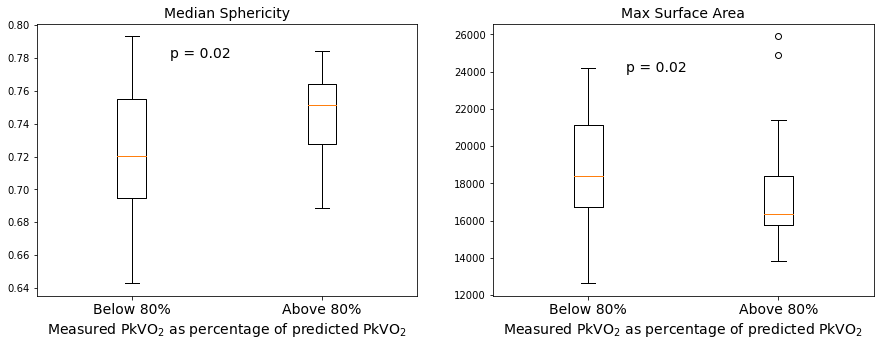

In [54]:
box_plot_func('Median Sphericity', 'Max Surface Area',  pyrads_3d_df, \
        'median_original_shape_Sphericity', 'max_original_shape_SurfaceArea', 0.78, 24000)

31 20


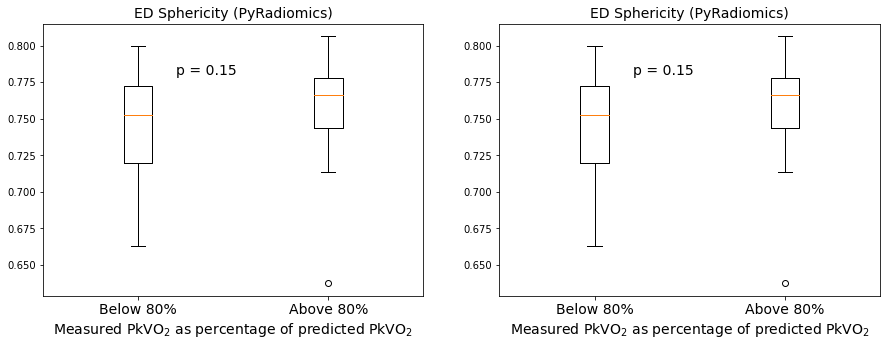

In [55]:
box_plot_func('ED Sphericity (PyRadiomics)', 'ED Sphericity (PyRadiomics)',  pyrads_3d_df, \
        'ed_val_original_shape_Sphericity', 'ed_val_original_shape_Sphericity', 0.78, 0.78)

In [56]:
pyrads_3d_expanded_df = pd.read_csv('pyrads_3d_expanded.csv')
pyrads_3d_expanded_df.drop(columns='Unnamed: 0',inplace=True);
pyrads_3d_expanded_df.tail()

,min_original_shape_Elongation,min_original_shape_Flatness,min_original_shape_LeastAxisLength,min_original_shape_MajorAxisLength,min_original_shape_Maximum2DDiameterColumn,min_original_shape_Maximum2DDiameterRow,min_original_shape_Maximum2DDiameterSlice,min_original_shape_Maximum3DDiameter,min_original_shape_MeshVolume,min_original_shape_MinorAxisLength,...,ed_val_original_shape_Maximum2DDiameterRow,ed_val_original_shape_Maximum2DDiameterSlice,ed_val_original_shape_Maximum3DDiameter,ed_val_original_shape_MeshVolume,ed_val_original_shape_MinorAxisLength,ed_val_original_shape_Sphericity,ed_val_original_shape_SurfaceArea,ed_val_original_shape_SurfaceVolumeRatio,ed_val_original_shape_VoxelVolume,patient_id
52,0.423486,0.405396,36.770433,81.648989,87.278813,95.566158,45.572916,95.843931,71313.778629,38.641109,...,121.891046,62.645770,122.108949,173892.238241,51.966815,0.711070,21188.109261,0.121846,175136.711115,191
53,0.554323,0.521529,41.394049,68.162287,80.331442,78.656072,52.810753,81.829095,78888.446268,43.155068,...,96.500000,69.129318,97.227905,179444.334157,59.380623,0.787104,19546.630021,0.108929,180641.008371,194
54,0.487977,0.464097,41.683664,78.313494,88.919595,88.919595,53.613586,91.079571,94621.476181,44.448484,...,115.852839,67.225844,116.367990,209996.905179,55.763007,0.771394,22148.785009,0.105472,211065.257725,199
55,0.427003,0.399196,39.397145,89.648559,93.082459,90.181263,48.641483,94.464491,83005.842193,40.316971,...,119.453973,71.466702,120.575357,265021.215117,62.542178,0.719850,27718.023592,0.104588,266333.810003,200
56,0.355943,0.334838,35.580595,104.143548,110.974380,111.869095,48.641483,112.136118,84752.091845,37.963735,...,127.113651,67.546379,128.362341,215074.487423,57.902413,0.675245,25708.809267,0.119534,216488.434572,201


In [57]:
pyrads_3d_expanded_df = pyrads_3d_expanded_df[~pyrads_3d_expanded_df['patient_id'].isin(low_lv_ef)]
pyrads_3d_expanded_df.shape

(51, 113)

In [58]:
u_test_pyrads_3d_expanded_features, _, _ = u_test_func(pyrads_3d_expanded_df, numerical_columns)

In [59]:
u_test_pyrads_3d_features_dict = {feature[0]:feature[1] for feature in u_test_pyrads_3d_features}
u_test_pyrads_3d_expanded_features_dict = {feature[0]:feature[1] for feature in u_test_pyrads_3d_expanded_features}

In [60]:
significant_feat = [ent for ent in u_test_pyrads_3d_features if ent[1] < 0.08]

In [61]:
significant_feat

[('min_original_shape_Maximum2DDiameterSlice', 0.02339819528913122),
 ('min_original_shape_Sphericity', 0.04040636792387985),
 ('max_original_shape_LeastAxisLength', 0.027452700628444175),
 ('max_original_shape_Maximum2DDiameterSlice', 0.0766250838141773),
 ('max_original_shape_MeshVolume', 0.05793407633793944),
 ('max_original_shape_MinorAxisLength', 0.028694823729988765),
 ('max_original_shape_Sphericity', 0.05152607727654774),
 ('max_original_shape_SurfaceArea', 0.014987172362215128),
 ('max_original_shape_VoxelVolume', 0.059056363310778806),
 ('mean_original_shape_Maximum2DDiameterSlice', 0.07261352849922208),
 ('mean_original_shape_MeshVolume', 0.06495241567094262),
 ('mean_original_shape_MinorAxisLength', 0.06495241567094262),
 ('mean_original_shape_Sphericity', 0.0251027186037741),
 ('mean_original_shape_SurfaceArea', 0.01816304658584517),
 ('mean_original_shape_VoxelVolume', 0.06254312455321946),
 ('median_original_shape_MajorAxisLength', 0.043873463535907924),
 ('median_origin

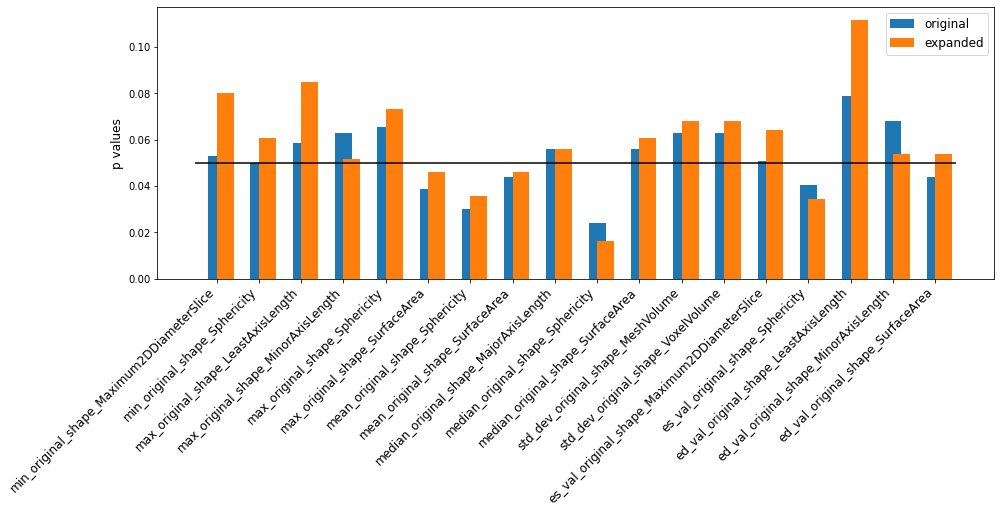

In [47]:
plt.figure(figsize=(15,5))
x = [feature[0] for feature in significant_feat]
y1 = [u_test_pyrads_3d_features_dict[feature[0]] for feature in significant_feat]
y2 = [u_test_pyrads_3d_expanded_features_dict[feature[0]] for feature in significant_feat]
plt.bar(x,y1,label='original',width=0.4)
plt.bar(x,y2,label='expanded',width=0.4, align='edge')
plt.xticks(x, rotation=45, ha="right",fontsize=12)
#plt.yscale('log')
plt.hlines(0.05, -0.5,17.5,colors='black')
plt.ylabel('p values',fontsize=12)
plt.legend(fontsize=12);

### 3D Fractal features

In [45]:
fractals_3d_df = pd.read_csv('fractals_3d.csv')
fractals_3d_df.drop(columns='Unnamed: 0',inplace=True);
fractals_3d_df.head()

,lv_max_slope,lv_max_inc,lv_min_slope,lv_min_inc,lv_mean_slope,lv_mean_inc,lv_median_slope,lv_median_inc,lv_ed_slope,lv_ed_inc,...,lvmc_min_inc,lvmc_mean_slope,lvmc_mean_inc,lvmc_median_slope,lvmc_median_inc,lvmc_ed_slope,lvmc_ed_inc,lvmc_es_slope,lvmc_es_inc,patient_id
0,2.624124,8.096453,2.464594,7.874847,2.532024,7.968338,2.525896,7.972465,2.547586,8.023841,...,7.766741,2.332112,7.916004,2.319986,7.937443,2.319986,7.938323,2.255928,7.766741,100B
1,2.301350,7.408147,1.930682,6.224656,2.131324,6.932862,2.161029,7.201002,2.288001,7.408147,...,7.245306,2.216174,7.559976,2.219100,7.620948,2.333231,7.789913,2.269816,7.636487,101B
2,3.075653,8.252223,2.816428,7.521387,2.983759,7.951634,3.024954,8.071304,3.075653,8.252223,...,8.137937,2.907728,8.209653,2.904066,8.213547,2.843704,8.154597,2.947627,8.252124,103
3,2.587199,7.877344,2.343175,7.341483,2.505436,7.714917,2.531323,7.788237,2.435251,7.821467,...,7.784995,2.373859,7.855800,2.377858,7.861908,2.325445,7.819717,2.381442,7.819266,105B
4,2.557690,7.792839,2.048207,6.216915,2.405354,7.158140,2.426958,7.246218,2.555350,7.792839,...,7.537170,2.417745,7.761672,2.432243,7.819010,2.437533,7.942699,2.347765,7.537170,109


In [46]:
fractals_3d_df = fractals_3d_df[~fractals_3d_df['patient_id'].isin(low_lv_ef)]
fractals_3d_df.shape

(51, 25)

In [47]:
fractals_3d_columns = fractals_3d_df.columns
numerical_columns = fractals_3d_columns.drop(['patient_id']).values

In [48]:
outlier_features = outlier_func(fractals_3d_df, numerical_columns, 3)
outlier_features

['lv_max_slope', 'lv_max_inc', 'lv_ed_inc', 'lv_es_slope', 'lvmc_max_slope']

In [49]:
fractals_3d_df_scaled = fractals_3d_df.copy(deep=True)
fractals_3d_df_scaled[numerical_columns] = scaler.fit_transform(fractals_3d_df[numerical_columns])

<AxesSubplot:>

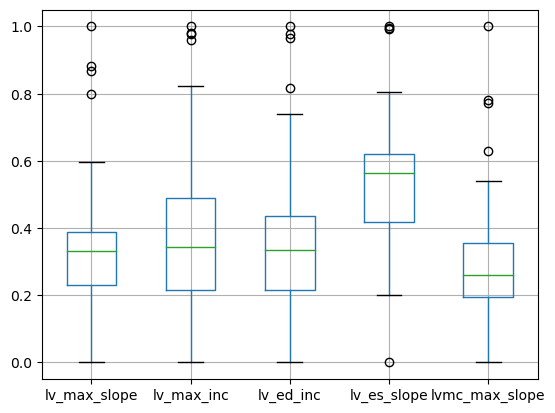

In [50]:
fractals_3d_df_scaled.boxplot(column = list(outlier_features))

In [68]:
feature='lv_es_slope'
fractals_3d_df.sort_values(by=[feature], ascending=False)[['patient_id',feature]].head()

,patient_id,lv_es_slope
16,133,2.823060
2,103,2.816428
53,194,2.812718
3,105B,2.587199
43,179,2.480317


#### U test with 3d fractal features

In [51]:
fractals_3d_df.shape

(51, 25)

In [52]:
u_test_fractals_3d_features, _, _ = u_test_func(fractals_3d_df, numerical_columns)

In [55]:
significant_feat = [ent for ent in u_test_fractals_3d_features if ent[1] < 0.2]
print('significant features: (feature name, p-value)')
[print(ent[0], round(ent[1],3)) for ent in sorted(significant_feat, key = lambda x: x[1])];

significant features: (feature name, p-value)
lv_min_slope 0.107
lv_es_slope 0.145
lvmc_min_slope 0.145


In [56]:
important_features.extend([feat[0] for feat in significant_feat])
important_features

['std_dev_original_shape_VoxelVolume',
 'median_original_shape_Sphericity',
 'ed_val_original_shape_SurfaceArea',
 'lvmc_vol_ed',
 'mean_original_shape_Sphericity',
 'es_val_original_shape_Maximum2DDiameterSlice',
 'lv_std',
 'std_dev_original_shape_MeshVolume',
 'min_original_shape_Maximum2DDiameterSlice',
 'max_original_shape_SurfaceArea',
 'mean_original_shape_SurfaceArea',
 'max_original_shape_LeastAxisLength',
 'median_original_shape_SurfaceArea',
 'min_original_shape_VoxelVolume',
 'mean_original_shape_LeastAxisLength',
 'median_original_shape_SurfaceVolumeRatio',
 'median_original_shape_MinorAxisLength',
 'ed_val_original_shape_Maximum3DDiameter',
 'max_original_shape_Maximum2DDiameterColumn',
 'max_original_shape_Maximum2DDiameterRow',
 'mean_original_shape_Maximum3DDiameter',
 'max_original_shape_MeshVolume',
 'max_original_shape_Maximum2DDiameterColumn',
 'ed_val_original_shape_MajorAxisLength',
 'lv_min_slope',
 'lv_es_slope',
 'lvmc_min_slope']

In [57]:
pids = fractals_3d_df.patient_id.values
pkvo2_vals = []
petco2_vals = []
for pid in pids:
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    pkvo2_vals.append(cpet_record['VO2 (MAX):'].values[0])
    petco2_vals.append(cpet_record['PetCO2.2'].values[0])    
    
fractals_3d_df['pkvo2'] = pkvo2_vals
fractals_3d_df['petco2'] = petco2_vals

In [58]:
response = pkvo2_vals
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(fractals_3d_df[predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],3)))
print('significant features: (feature name, p-value)')
[print(ent) for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.1];

significant features: (feature name, p-value)
('lvmc_min_inc', 0.168, 0.003)
('lv_min_inc', 0.108, 0.018)
('lvmc_min_slope', 0.101, 0.023)


In [59]:
response = fractals_3d_df[~fractals_3d_df['patient_id'].isin(null_petco2_pids)]['petco2']
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(fractals_3d_df[~fractals_3d_df['patient_id'].isin(null_petco2_pids)][predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],6)))
print('significant features: \n(feature name, R^2, p-value)\n')
[print(ent) for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.2];

NameError: name 'null_petco2_pids' is not defined

31 20


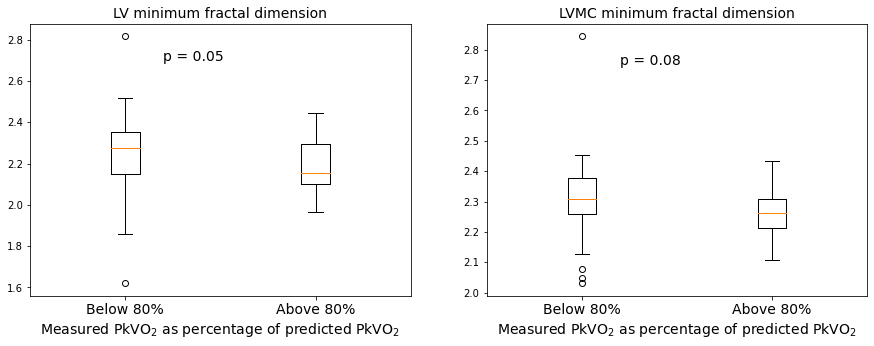

In [78]:
box_plot_func('LV minimum fractal dimension', 'LVMC minimum fractal dimension',  fractals_3d_df, \
        'lv_min_slope', 'lvmc_min_slope', 2.7, 2.75)

In [88]:
fractals_3d_expanded_df = pd.read_csv('fractals_3d_expanded.csv')
fractals_3d_expanded_df.drop(columns='Unnamed: 0',inplace=True);
fractals_3d_expanded_df.head()

,lv_max_slope,lv_max_inc,lv_min_slope,lv_min_inc,lv_mean_slope,lv_mean_inc,lv_median_slope,lv_median_inc,lv_ed_slope,lv_ed_inc,...,lvmc_min_inc,lvmc_mean_slope,lvmc_mean_inc,lvmc_median_slope,lvmc_median_inc,lvmc_ed_slope,lvmc_ed_inc,lvmc_es_slope,lvmc_es_inc,patient_id
0,2.682362,8.279426,2.529146,8.088276,2.601897,8.176447,2.604391,8.188470,2.644599,8.259575,...,8.032622,2.421440,8.214297,2.419377,8.236408,2.419377,8.275266,2.379106,8.109563,100B
1,2.366711,7.622409,2.017370,6.527648,2.188176,7.173653,2.228478,7.427520,2.366711,7.622409,...,7.580548,2.328778,7.862392,2.320984,7.917705,2.451578,8.077189,2.351508,7.863588,101B
2,3.132175,8.428253,2.893847,7.747357,3.031786,8.122570,3.048853,8.231080,3.132175,8.428253,...,8.398204,3.034668,8.505831,3.028395,8.501493,2.912487,8.398204,3.075625,8.537273,103
3,2.533848,8.014906,2.426563,7.575283,2.487910,7.827499,2.490941,7.858213,2.496195,8.014906,...,8.116180,2.507367,8.171036,2.516806,8.170515,2.413867,8.119733,2.504995,8.116180,105B
4,2.598474,7.958400,2.234113,6.619929,2.464876,7.390929,2.521695,7.532876,2.598474,7.958400,...,7.752909,2.503252,8.030093,2.539340,8.141504,2.518066,8.180590,2.406509,7.752909,109


In [95]:
fractals_3d_expanded_df = fractals_3d_expanded_df[~fractals_3d_expanded_df['patient_id'].isin(low_lv_ef)]
fractals_3d_expanded_df.shape

NameError: name 'fractals_3d_expanded_df' is not defined

In [94]:
assert fractals_3d_expanded_df.shape == fractals_3d_df.shape

NameError: name 'fractals_3d_expanded_df' is not defined

In [58]:
u_test_fractals_3d_expanded_features, _, _ = u_test_func(fractals_3d_expanded_df, numerical_columns)

In [59]:
u_test_fractals_3d_features_dict = {feature[0]:feature[1] for feature in u_test_fractals_3d_features}
u_test_fractals_3d_expanded_features_dict = {feature[0]:feature[1] for feature in u_test_fractals_3d_expanded_features}

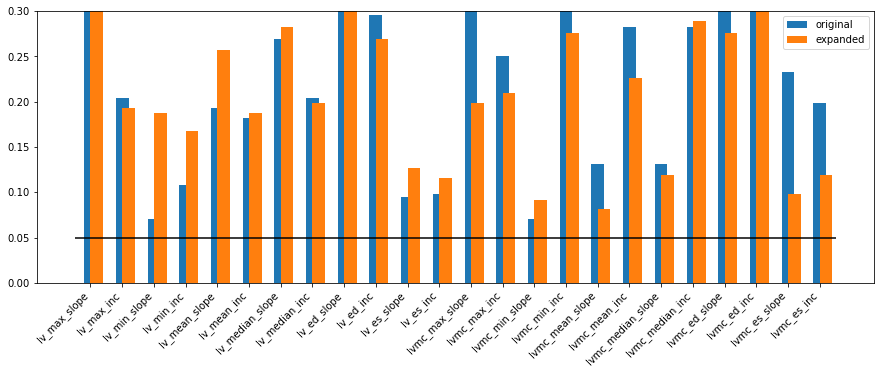

In [60]:
plt.figure(figsize=(15,5))
x = [feature for feature in numerical_columns]
y1 = [u_test_fractals_3d_features_dict[feature] for feature in numerical_columns]
y2 = [u_test_fractals_3d_expanded_features_dict[feature] for feature in numerical_columns]
plt.bar(x,y1,label='original',width=0.4)
plt.bar(x,y2,label='expanded',width=0.4, align='edge')
plt.xticks(x, rotation=45, ha="right")
#plt.yscale('log')
plt.hlines(0.05, -0.5,23.5,colors='black')
plt.ylim(0,0.3)
plt.legend();

## CCIPD morphology features

In [60]:
ccipd_shape_2d_df = pd.read_excel('shape_8.xlsx').T
ccipd_shape_2d_df.columns = ccipd_shape_2d_df.iloc[0]
ccipd_shape_2d_df = ccipd_shape_2d_df.iloc[1:]
ccipd_shape_2d_df['patient_id'] = ccipd_shape_2d_df.index.values
ccipd_shape_2d_df.reset_index(inplace=True, drop=True)
ccipd_shape_2d_df = ccipd_shape_2d_df.rename_axis(None, axis=1)
ccipd_shape_2d_df.head()

,Phase,lv_avg_average_radial_ratio,lv_std_average_radial_ratio,lv_avg_area_overlap_ratio,lv_std_area_overlap_ratio,lv_avg_compactness,lv_std_compactness,lv_avg_convexity,lv_std_convexity,lv_avg_Hausdorff_Dimension,...,lvmc_std_compactness,lvmc_avg_convexity,lvmc_std_convexity,lvmc_avg_Hausdorff_Dimension,lvmc_std_Hausdorff_Dimension,lvmc_avg_smoothness,lvmc_std_smoothness,lvmc_avg_std_distance_ratio,lvmc_std_std_distance_ratio,patient_id
0,ed10,0.853717,0.056159,0.794044,0.09929,13.23571,0.296948,0.964794,0.00817,1.039296,...,4.629694,0.962437,0.006079,1.201052,0.07069,18.895799,3.929156,0.04572,0.022612,100B
1,es4,0.873973,0.026149,0.829406,0.049693,13.154499,0.411352,0.965983,0.007253,0.986385,...,6.340455,0.962548,0.005264,1.182248,0.047447,19.365184,3.923945,0.041816,0.014645,100B.1
2,ed0,0.864346,0.033201,0.824055,0.062689,12.844654,0.539633,0.971635,0.00612,0.924749,...,3.318184,0.963873,0.004567,1.122989,0.034393,17.623827,3.466032,0.041742,0.020314,101B
3,es4,0.866036,0.033473,0.885459,0.06968,12.15369,0.83334,0.9702,0.008287,0.762343,...,2.135214,0.963762,0.003952,0.991932,0.108874,15.200941,4.275771,0.056368,0.040442,101B.1
4,ed0,0.881539,0.03312,0.840172,0.055447,13.224271,0.285614,0.962707,0.008224,1.045217,...,2.777332,0.963431,0.004889,1.09891,0.068109,20.577368,3.58046,0.035157,0.009932,103


In [61]:
def extract_phase_shape_2d_df(shape_2d_df, phase):
    num_rows = shape_2d_df.shape[0]
    df = pd.DataFrame()
    for i in range(num_rows):
        row_entries = shape_2d_df.iloc[i]
        if phase in row_entries['Phase']:
            df = df.append(row_entries)
            df.loc[i,'patient_id'] = str(row_entries['patient_id']).split('.')[0]
    df.reset_index(inplace=True, drop=True)
    df = df.drop(columns=['Phase'])
    return df

In [62]:
ed_shape_2d_df = extract_phase_shape_2d_df(ccipd_shape_2d_df, 'ed')
es_shape_2d_df = extract_phase_shape_2d_df(ccipd_shape_2d_df, 'es')

/var/folders/99/3y_6msy17fl4qy16j55dfc4w0000gn/T/ipykernel_45921/1012467570.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_entries)
/var/folders/99/3y_6msy17fl4qy16j55dfc4w0000gn/T/ipykernel_45921/1012467570.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_entries)
/var/folders/99/3y_6msy17fl4qy16j55dfc4w0000gn/T/ipykernel_45921/1012467570.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_entries)
/var/folders/99/3y_6msy17fl4qy16j55dfc4w0000gn/T/ipykernel_45921/1012467570.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_entries)
/var/folders/99/3y_6

In [63]:
ed_shape_2d_df.head()

,lv_avg_average_radial_ratio,lv_std_average_radial_ratio,lv_avg_area_overlap_ratio,lv_std_area_overlap_ratio,lv_avg_compactness,lv_std_compactness,lv_avg_convexity,lv_std_convexity,lv_avg_Hausdorff_Dimension,lv_std_Hausdorff_Dimension,...,lvmc_std_compactness,lvmc_avg_convexity,lvmc_std_convexity,lvmc_avg_Hausdorff_Dimension,lvmc_std_Hausdorff_Dimension,lvmc_avg_smoothness,lvmc_std_smoothness,lvmc_avg_std_distance_ratio,lvmc_std_std_distance_ratio,patient_id
0,0.853717,0.056159,0.794044,0.099290,13.235710,0.296948,0.964794,0.008170,1.039296,0.058331,...,4.629694,0.962437,0.006079,1.201052,0.070690,18.895799,3.929156,0.045720,0.022612,100B
1,0.864346,0.033201,0.824055,0.062689,12.844654,0.539633,0.971635,0.006120,0.924749,0.098095,...,3.318184,0.963873,0.004567,1.122989,0.034393,17.623827,3.466032,0.041742,0.020314,101B
2,0.881539,0.033120,0.840172,0.055447,13.224271,0.285614,0.962707,0.008224,1.045217,0.048148,...,2.777332,0.963431,0.004889,1.098910,0.068109,20.577368,3.580460,0.035157,0.009932,103
3,0.900517,0.022261,0.879287,0.034969,13.186463,0.221792,0.961618,0.003998,0.886882,0.038052,...,4.376389,0.959868,0.005119,1.085385,0.056422,21.303569,3.572931,0.037064,0.007721,105B
4,0.860081,0.029107,0.823982,0.062522,12.917694,0.950794,0.966809,0.011090,0.830377,0.093879,...,5.327416,0.960738,0.007502,1.042750,0.077333,18.227353,3.299459,0.051179,0.018721,109


In [64]:
def convert_str_to_float(df):
    df_columns = df.columns
    numerical_columns = df_columns.drop(['patient_id']).values
    num_rows = df.shape[0]

    for i in range(num_rows):
        for col in numerical_columns:
            df.loc[i][col] = float(df.loc[i][col])
    return df

In [65]:
ed_shape_2d_df = convert_str_to_float(ed_shape_2d_df)
es_shape_2d_df = convert_str_to_float(es_shape_2d_df)

/var/folders/99/3y_6msy17fl4qy16j55dfc4w0000gn/T/ipykernel_45921/31685950.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[i][col] = float(df.loc[i][col])
/var/folders/99/3y_6msy17fl4qy16j55dfc4w0000gn/T/ipykernel_45921/31685950.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[i][col] = float(df.loc[i][col])


In [66]:
es_shape_2d_df.describe()

,lv_avg_average_radial_ratio,lv_std_average_radial_ratio,lv_avg_area_overlap_ratio,lv_std_area_overlap_ratio,lv_avg_compactness,lv_std_compactness,lv_avg_convexity,lv_std_convexity,lv_avg_Hausdorff_Dimension,lv_std_Hausdorff_Dimension,...,lvmc_avg_compactness,lvmc_std_compactness,lvmc_avg_convexity,lvmc_std_convexity,lvmc_avg_Hausdorff_Dimension,lvmc_std_Hausdorff_Dimension,lvmc_avg_smoothness,lvmc_std_smoothness,lvmc_avg_std_distance_ratio,lvmc_std_std_distance_ratio
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,...,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,0.843626,0.044758,0.821139,0.071627,12.475987,0.910644,0.971920,0.011357,0.874602,0.092286,...,20.740232,4.488978,0.963907,0.009865,1.096445,0.084122,16.560520,3.871840,0.045134,0.015913
std,0.021622,0.017512,0.040547,0.026837,0.513371,0.399620,0.005337,0.004223,0.070080,0.038908,...,3.300826,2.544319,0.007950,0.018017,0.059374,0.038399,2.524266,1.195093,0.007662,0.008354
min,0.795331,0.014854,0.749413,0.019306,10.971733,0.242789,0.956621,0.003442,0.663306,0.031940,...,15.848370,1.229996,0.909878,0.003936,0.991932,0.019445,11.937794,1.905929,0.030357,0.004509
25%,0.829414,0.033473,0.789129,0.052889,12.188905,0.652074,0.969461,0.008471,0.830050,0.064846,...,18.958461,3.112640,0.962821,0.005482,1.054040,0.049707,15.061590,2.966322,0.040434,0.009357
50%,0.843534,0.042093,0.823809,0.070128,12.570211,0.864271,0.971800,0.011092,0.875150,0.089172,...,20.254297,3.913042,0.963960,0.007217,1.083325,0.084542,16.166705,3.923945,0.044124,0.013431
75%,0.860116,0.054588,0.849429,0.088920,12.785561,1.160015,0.974569,0.013947,0.918807,0.109607,...,21.566637,5.381934,0.967283,0.009188,1.142304,0.108467,17.499242,4.492828,0.048285,0.020898
max,0.892210,0.108958,0.907986,0.135555,13.800228,2.261580,0.987050,0.030234,1.059094,0.205008,...,33.992499,17.490243,0.971742,0.142120,1.328175,0.169917,24.455107,6.957113,0.067629,0.040442


In [67]:
ed_shape_2d_df.to_csv('ed_shape_2d.csv')
es_shape_2d_df.to_csv('es_shape_2d.csv')

In [68]:
ed_shape_2d_df = ed_shape_2d_df[~ed_shape_2d_df['patient_id'].isin(low_lv_ef)]
ed_shape_2d_df.shape

(51, 29)

In [69]:
ed_shape_2d_columns = ed_shape_2d_df.columns
numerical_columns = ed_shape_2d_columns.drop(['patient_id']).values
outlier_features = outlier_func(ed_shape_2d_df, numerical_columns, 4)
outlier_features

['lv_avg_area_overlap_ratio', 'lv_std_compactness']

<AxesSubplot:>

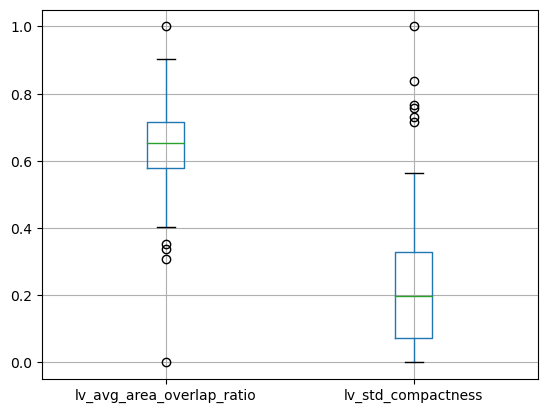

In [70]:
ed_shape_2d_df_scaled = ed_shape_2d_df.copy(deep=True)
ed_shape_2d_df_scaled[numerical_columns] = scaler.fit_transform(ed_shape_2d_df[numerical_columns])
ed_shape_2d_df_scaled.boxplot(column = list(outlier_features))

In [71]:
ed_shape_2d_df_scaled.sort_values(by=['lv_avg_area_overlap_ratio']).head()

,lv_avg_average_radial_ratio,lv_std_average_radial_ratio,lv_avg_area_overlap_ratio,lv_std_area_overlap_ratio,lv_avg_compactness,lv_std_compactness,lv_avg_convexity,lv_std_convexity,lv_avg_Hausdorff_Dimension,lv_std_Hausdorff_Dimension,...,lvmc_std_compactness,lvmc_avg_convexity,lvmc_std_convexity,lvmc_avg_Hausdorff_Dimension,lvmc_std_Hausdorff_Dimension,lvmc_avg_smoothness,lvmc_std_smoothness,lvmc_avg_std_distance_ratio,lvmc_std_std_distance_ratio,patient_id
39,0.000000,0.419758,0.000000,0.240181,1.000000,0.061702,0.013756,0.344102,0.543077,0.171274,...,0.257500,0.000000,0.339593,0.630654,0.417887,1.000000,0.899667,1.000000,0.237331,169
38,0.240138,0.647684,0.308206,0.640522,0.544784,0.328867,0.319908,0.614013,0.474150,0.152618,...,0.316901,0.419170,0.155785,0.833698,0.230907,0.098980,0.041505,0.780258,0.452143,168
13,0.288151,0.928950,0.335980,0.648853,0.416581,0.114681,0.720908,0.161386,0.568896,0.375993,...,0.153823,0.387949,0.579469,0.371809,0.295646,0.343129,0.647811,0.287159,0.423774,129
23,0.254086,0.983256,0.352043,0.872388,0.684492,0.375746,0.216028,0.294951,1.000000,0.306833,...,0.031167,0.440944,0.097000,0.660436,0.441796,0.088483,0.175537,0.824838,1.000000,146
32,0.440857,0.224977,0.404182,0.140852,0.570746,0.041536,0.243558,0.229361,0.000000,0.000000,...,0.078113,0.433002,0.439064,0.223844,0.035933,0.239725,0.000000,0.675402,0.307037,159


In [72]:
u_test_ed_shape_2d_features, _, _ = u_test_func(ed_shape_2d_df, numerical_columns)

In [74]:
significant_feat = [ent for ent in u_test_ed_shape_2d_features if ent[1] < 0.1]
print('significant features: (feature name, p-value)')
[print(ent[0], round(ent[1],3)) for ent in sorted(significant_feat, key = lambda x: x[1])];

significant features: (feature name, p-value)
lv_std_compactness 0.078


In [75]:
important_features.extend([feat[0] for feat in significant_feat])
important_features

['std_dev_original_shape_VoxelVolume',
 'median_original_shape_Sphericity',
 'ed_val_original_shape_SurfaceArea',
 'lvmc_vol_ed',
 'mean_original_shape_Sphericity',
 'es_val_original_shape_Maximum2DDiameterSlice',
 'lv_std',
 'std_dev_original_shape_MeshVolume',
 'min_original_shape_Maximum2DDiameterSlice',
 'max_original_shape_SurfaceArea',
 'mean_original_shape_SurfaceArea',
 'max_original_shape_LeastAxisLength',
 'median_original_shape_SurfaceArea',
 'min_original_shape_VoxelVolume',
 'mean_original_shape_LeastAxisLength',
 'median_original_shape_SurfaceVolumeRatio',
 'median_original_shape_MinorAxisLength',
 'ed_val_original_shape_Maximum3DDiameter',
 'max_original_shape_Maximum2DDiameterColumn',
 'max_original_shape_Maximum2DDiameterRow',
 'mean_original_shape_Maximum3DDiameter',
 'max_original_shape_MeshVolume',
 'max_original_shape_Maximum2DDiameterColumn',
 'ed_val_original_shape_MajorAxisLength',
 'lv_min_slope',
 'lv_es_slope',
 'lvmc_min_slope',
 'lv_std_compactness']

In [76]:
es_shape_2d_df = es_shape_2d_df[~es_shape_2d_df['patient_id'].isin(low_lv_ef)]
es_shape_2d_df.shape

(51, 29)

In [80]:
u_test_es_shape_2d_features, _, _ = u_test_func(es_shape_2d_df, numerical_columns)
significant_feat = [ent for ent in u_test_es_shape_2d_features if ent[1] < 0.15]
print('significant features: (feature name, p-value)')
[print(ent[0], round(ent[1],3)) for ent in sorted(significant_feat, key = lambda x: x[1])];

significant features: (feature name, p-value)
lv_std_average_radial_ratio 0.103
lv_std_std_distance_ratio 0.125


In [81]:
important_features.extend([feat[0] for feat in significant_feat])
important_features

['std_dev_original_shape_VoxelVolume',
 'median_original_shape_Sphericity',
 'ed_val_original_shape_SurfaceArea',
 'lvmc_vol_ed',
 'mean_original_shape_Sphericity',
 'es_val_original_shape_Maximum2DDiameterSlice',
 'lv_std',
 'std_dev_original_shape_MeshVolume',
 'min_original_shape_Maximum2DDiameterSlice',
 'max_original_shape_SurfaceArea',
 'mean_original_shape_SurfaceArea',
 'max_original_shape_LeastAxisLength',
 'median_original_shape_SurfaceArea',
 'min_original_shape_VoxelVolume',
 'mean_original_shape_LeastAxisLength',
 'median_original_shape_SurfaceVolumeRatio',
 'median_original_shape_MinorAxisLength',
 'ed_val_original_shape_Maximum3DDiameter',
 'max_original_shape_Maximum2DDiameterColumn',
 'max_original_shape_Maximum2DDiameterRow',
 'mean_original_shape_Maximum3DDiameter',
 'max_original_shape_MeshVolume',
 'max_original_shape_Maximum2DDiameterColumn',
 'ed_val_original_shape_MajorAxisLength',
 'lv_min_slope',
 'lv_es_slope',
 'lvmc_min_slope',
 'lv_std_compactness',
 'lv_s

## Multivariate Analysis

In [161]:
important_features.extend(['median_original_shape_Maximum3DDiameter', 'median_original_shape_MajorAxisLength'])

In [162]:
important_features = list(set(important_features))
important_features

['lv_std_average_radial_ratio',
 'lvmc_min_slope',
 'max_original_shape_Maximum2DDiameterRow',
 'min_original_shape_VoxelVolume',
 'lv_std',
 'lv_std_std_distance_ratio',
 'min_original_shape_Maximum2DDiameterSlice',
 'max_original_shape_LeastAxisLength',
 'median_original_shape_SurfaceVolumeRatio',
 'mean_original_shape_Sphericity',
 'median_original_shape_SurfaceArea',
 'median_original_shape_MajorAxisLength',
 'mean_original_shape_SurfaceArea',
 'median_original_shape_Maximum3DDiameter',
 'lv_min_slope',
 'max_original_shape_MeshVolume',
 'median_original_shape_Sphericity',
 'ed_val_original_shape_SurfaceArea',
 'ed_val_original_shape_Maximum3DDiameter',
 'std_dev_original_shape_MeshVolume',
 'mean_original_shape_LeastAxisLength',
 'lvmc_vol_min',
 'mean_original_shape_Maximum3DDiameter',
 'lv_std_compactness',
 'std_dev_original_shape_VoxelVolume',
 'lvmc_vol_ed',
 'max_original_shape_Maximum2DDiameterColumn',
 'es_val_original_shape_Maximum2DDiameterSlice',
 'median_original_shape

In [163]:
important_features = important_features + ['lvmc_vol_min', 'median_original_shape_SurfaceVolumeRatio']
important_features = list(set(important_features))

In [164]:
pyrads_df = pd.read_csv('pyrads_3d.csv')
pyrads_df.drop(columns=['Unnamed: 0'],inplace=True)
common_features = list(set(pyrads_df.columns.values) & set(important_features))
pyrads_df_imp = pyrads_df[['patient_id']+common_features]
pyrads_df_imp.head()

,patient_id,max_original_shape_Maximum2DDiameterRow,min_original_shape_VoxelVolume,min_original_shape_Maximum2DDiameterSlice,max_original_shape_LeastAxisLength,median_original_shape_SurfaceVolumeRatio,mean_original_shape_Sphericity,median_original_shape_SurfaceArea,median_original_shape_MajorAxisLength,mean_original_shape_SurfaceArea,...,ed_val_original_shape_Maximum3DDiameter,std_dev_original_shape_MeshVolume,mean_original_shape_LeastAxisLength,mean_original_shape_Maximum3DDiameter,std_dev_original_shape_VoxelVolume,max_original_shape_Maximum2DDiameterColumn,es_val_original_shape_Maximum2DDiameterSlice,median_original_shape_MinorAxisLength,ed_val_original_shape_MajorAxisLength,max_original_shape_SurfaceArea
0,100B,107.108590,164954.4375,63.372904,55.777662,0.116928,0.718340,21675.082960,95.481710,21669.761156,...,106.501247,9025.864975,52.517169,104.658825,8939.470270,105.088356,65.689254,55.707019,94.464147,22765.260134
1,101B,93.324116,39867.9375,48.961879,47.814915,0.167855,0.656805,15414.725490,76.339074,13893.243204,...,93.682392,29918.898255,40.987305,84.893331,30097.474262,90.341366,51.269204,48.743331,85.350038,17302.203617
2,103,104.254796,104983.3125,53.582442,53.529400,0.116467,0.743902,19520.655020,90.643515,18523.079710,...,109.454400,33449.082227,48.452210,102.416806,33476.877838,98.924529,55.900861,56.543431,91.559889,21511.798471
3,105B,108.182788,123597.3750,57.835029,57.459717,0.112936,0.744217,21029.726530,96.370229,20414.987479,...,109.117268,33467.621782,51.684685,104.706022,33533.562515,107.108590,57.835029,55.507630,96.997568,23763.375245
4,109,101.595091,42440.0625,42.085107,47.679752,0.149964,0.720003,13287.131248,84.183141,13585.015101,...,102.946360,41660.065661,38.089976,88.857282,41850.236628,100.842777,42.085107,44.172514,89.894066,18885.775024


In [165]:
vol_df = pd.read_csv('vol.csv')
vol_df.drop(columns=['Unnamed: 0'],inplace=True)
common_features = list(set(vol_df.columns.values) & set(important_features))
vol_df_imp = vol_df[['patient_id']+common_features]
vol_df_imp.head()

,patient_id,lvmc_vol_min,lvmc_vol_ed,lv_std
0,100B,118114.6875,139436.2500,2168.140010
1,101B,96996.1875,123462.0000,9517.657049
2,103,144242.0625,144242.0625,10586.318292
3,105B,148777.1250,153582.9375,10604.243561
4,109,111413.6250,126507.9375,15817.902632


In [166]:
important_features_df = pd.merge(pyrads_df_imp, vol_df_imp, on="patient_id", how="left")
important_features_df.head()

,patient_id,max_original_shape_Maximum2DDiameterRow,min_original_shape_VoxelVolume,min_original_shape_Maximum2DDiameterSlice,max_original_shape_LeastAxisLength,median_original_shape_SurfaceVolumeRatio,mean_original_shape_Sphericity,median_original_shape_SurfaceArea,median_original_shape_MajorAxisLength,mean_original_shape_SurfaceArea,...,mean_original_shape_Maximum3DDiameter,std_dev_original_shape_VoxelVolume,max_original_shape_Maximum2DDiameterColumn,es_val_original_shape_Maximum2DDiameterSlice,median_original_shape_MinorAxisLength,ed_val_original_shape_MajorAxisLength,max_original_shape_SurfaceArea,lvmc_vol_min,lvmc_vol_ed,lv_std
0,100B,107.108590,164954.4375,63.372904,55.777662,0.116928,0.718340,21675.082960,95.481710,21669.761156,...,104.658825,8939.470270,105.088356,65.689254,55.707019,94.464147,22765.260134,118114.6875,139436.2500,2168.140010
1,101B,93.324116,39867.9375,48.961879,47.814915,0.167855,0.656805,15414.725490,76.339074,13893.243204,...,84.893331,30097.474262,90.341366,51.269204,48.743331,85.350038,17302.203617,96996.1875,123462.0000,9517.657049
2,103,104.254796,104983.3125,53.582442,53.529400,0.116467,0.743902,19520.655020,90.643515,18523.079710,...,102.416806,33476.877838,98.924529,55.900861,56.543431,91.559889,21511.798471,144242.0625,144242.0625,10586.318292
3,105B,108.182788,123597.3750,57.835029,57.459717,0.112936,0.744217,21029.726530,96.370229,20414.987479,...,104.706022,33533.562515,107.108590,57.835029,55.507630,96.997568,23763.375245,148777.1250,153582.9375,10604.243561
4,109,101.595091,42440.0625,42.085107,47.679752,0.149964,0.720003,13287.131248,84.183141,13585.015101,...,88.857282,41850.236628,100.842777,42.085107,44.172514,89.894066,18885.775024,111413.6250,126507.9375,15817.902632


In [167]:
fractals_3d_df = pd.read_csv('fractals_3d.csv')
fractals_3d_df.drop(columns=['Unnamed: 0'],inplace=True)
common_features = list(set(fractals_3d_df.columns.values) & set(important_features))
fractals_3d_df_imp = fractals_3d_df[['patient_id']+common_features]
fractals_3d_df_imp.head()

,patient_id,lv_min_slope,lvmc_min_slope,lv_es_slope
0,100B,2.464594,2.255928,2.494780
1,101B,1.930682,2.030273,2.006020
2,103,2.816428,2.843704,2.816428
3,105B,2.343175,2.325445,2.587199
4,109,2.048207,2.335396,2.048207


In [168]:
important_features_df = pd.merge(important_features_df, fractals_3d_df_imp, on="patient_id", how="left")
important_features_df.head()

,patient_id,max_original_shape_Maximum2DDiameterRow,min_original_shape_VoxelVolume,min_original_shape_Maximum2DDiameterSlice,max_original_shape_LeastAxisLength,median_original_shape_SurfaceVolumeRatio,mean_original_shape_Sphericity,median_original_shape_SurfaceArea,median_original_shape_MajorAxisLength,mean_original_shape_SurfaceArea,...,es_val_original_shape_Maximum2DDiameterSlice,median_original_shape_MinorAxisLength,ed_val_original_shape_MajorAxisLength,max_original_shape_SurfaceArea,lvmc_vol_min,lvmc_vol_ed,lv_std,lv_min_slope,lvmc_min_slope,lv_es_slope
0,100B,107.108590,164954.4375,63.372904,55.777662,0.116928,0.718340,21675.082960,95.481710,21669.761156,...,65.689254,55.707019,94.464147,22765.260134,118114.6875,139436.2500,2168.140010,2.464594,2.255928,2.494780
1,101B,93.324116,39867.9375,48.961879,47.814915,0.167855,0.656805,15414.725490,76.339074,13893.243204,...,51.269204,48.743331,85.350038,17302.203617,96996.1875,123462.0000,9517.657049,1.930682,2.030273,2.006020
2,103,104.254796,104983.3125,53.582442,53.529400,0.116467,0.743902,19520.655020,90.643515,18523.079710,...,55.900861,56.543431,91.559889,21511.798471,144242.0625,144242.0625,10586.318292,2.816428,2.843704,2.816428
3,105B,108.182788,123597.3750,57.835029,57.459717,0.112936,0.744217,21029.726530,96.370229,20414.987479,...,57.835029,55.507630,96.997568,23763.375245,148777.1250,153582.9375,10604.243561,2.343175,2.325445,2.587199
4,109,101.595091,42440.0625,42.085107,47.679752,0.149964,0.720003,13287.131248,84.183141,13585.015101,...,42.085107,44.172514,89.894066,18885.775024,111413.6250,126507.9375,15817.902632,2.048207,2.335396,2.048207


In [169]:
ed_shape_2d_df = pd.read_csv('ed_shape_2d.csv')
ed_shape_2d_df.drop(columns=['Unnamed: 0'],inplace=True)
common_features = list(set(ed_shape_2d_df.columns.values) & set(important_features))
ed_shape_2d_df_imp = ed_shape_2d_df[['patient_id']+common_features]
ed_shape_2d_df_imp.head()

,patient_id,lv_std_std_distance_ratio,lv_std_average_radial_ratio,lv_std_compactness
0,100B,0.025692,0.056159,0.296948
1,101B,0.021420,0.033201,0.539633
2,103,0.021518,0.033120,0.285614
3,105B,0.015523,0.022261,0.221792
4,109,0.021907,0.029107,0.950794


In [170]:
important_features_df = pd.merge(important_features_df, ed_shape_2d_df_imp, on="patient_id", how="left")
important_features_df.head()

,patient_id,max_original_shape_Maximum2DDiameterRow,min_original_shape_VoxelVolume,min_original_shape_Maximum2DDiameterSlice,max_original_shape_LeastAxisLength,median_original_shape_SurfaceVolumeRatio,mean_original_shape_Sphericity,median_original_shape_SurfaceArea,median_original_shape_MajorAxisLength,mean_original_shape_SurfaceArea,...,max_original_shape_SurfaceArea,lvmc_vol_min,lvmc_vol_ed,lv_std,lv_min_slope,lvmc_min_slope,lv_es_slope,lv_std_std_distance_ratio,lv_std_average_radial_ratio,lv_std_compactness
0,100B,107.108590,164954.4375,63.372904,55.777662,0.116928,0.718340,21675.082960,95.481710,21669.761156,...,22765.260134,118114.6875,139436.2500,2168.140010,2.464594,2.255928,2.494780,0.025692,0.056159,0.296948
1,101B,93.324116,39867.9375,48.961879,47.814915,0.167855,0.656805,15414.725490,76.339074,13893.243204,...,17302.203617,96996.1875,123462.0000,9517.657049,1.930682,2.030273,2.006020,0.021420,0.033201,0.539633
2,103,104.254796,104983.3125,53.582442,53.529400,0.116467,0.743902,19520.655020,90.643515,18523.079710,...,21511.798471,144242.0625,144242.0625,10586.318292,2.816428,2.843704,2.816428,0.021518,0.033120,0.285614
3,105B,108.182788,123597.3750,57.835029,57.459717,0.112936,0.744217,21029.726530,96.370229,20414.987479,...,23763.375245,148777.1250,153582.9375,10604.243561,2.343175,2.325445,2.587199,0.015523,0.022261,0.221792
4,109,101.595091,42440.0625,42.085107,47.679752,0.149964,0.720003,13287.131248,84.183141,13585.015101,...,18885.775024,111413.6250,126507.9375,15817.902632,2.048207,2.335396,2.048207,0.021907,0.029107,0.950794


In [171]:
es_shape_2d_df = pd.read_csv('es_shape_2d.csv')
es_shape_2d_df.drop(columns=['Unnamed: 0'],inplace=True)
common_features = list(set(es_shape_2d_df.columns.values) & set(important_features))
es_shape_2d_df_imp = es_shape_2d_df[['patient_id']+common_features]
es_shape_2d_df_imp.head()

,patient_id,lv_std_std_distance_ratio,lv_std_average_radial_ratio,lv_std_compactness
0,100B,0.010946,0.026149,0.411352
1,101B,0.013599,0.033473,0.833340
2,103,0.041558,0.057375,0.242789
3,105B,0.011419,0.021140,0.339924
4,109,0.020674,0.033041,0.898496


In [172]:
important_features_df = pd.merge(important_features_df, es_shape_2d_df_imp, on="patient_id", how="left")
important_features_df.head()

,patient_id,max_original_shape_Maximum2DDiameterRow,min_original_shape_VoxelVolume,min_original_shape_Maximum2DDiameterSlice,max_original_shape_LeastAxisLength,median_original_shape_SurfaceVolumeRatio,mean_original_shape_Sphericity,median_original_shape_SurfaceArea,median_original_shape_MajorAxisLength,mean_original_shape_SurfaceArea,...,lv_std,lv_min_slope,lvmc_min_slope,lv_es_slope,lv_std_std_distance_ratio_x,lv_std_average_radial_ratio_x,lv_std_compactness_x,lv_std_std_distance_ratio_y,lv_std_average_radial_ratio_y,lv_std_compactness_y
0,100B,107.108590,164954.4375,63.372904,55.777662,0.116928,0.718340,21675.082960,95.481710,21669.761156,...,2168.140010,2.464594,2.255928,2.494780,0.025692,0.056159,0.296948,0.010946,0.026149,0.411352
1,101B,93.324116,39867.9375,48.961879,47.814915,0.167855,0.656805,15414.725490,76.339074,13893.243204,...,9517.657049,1.930682,2.030273,2.006020,0.021420,0.033201,0.539633,0.013599,0.033473,0.833340
2,103,104.254796,104983.3125,53.582442,53.529400,0.116467,0.743902,19520.655020,90.643515,18523.079710,...,10586.318292,2.816428,2.843704,2.816428,0.021518,0.033120,0.285614,0.041558,0.057375,0.242789
3,105B,108.182788,123597.3750,57.835029,57.459717,0.112936,0.744217,21029.726530,96.370229,20414.987479,...,10604.243561,2.343175,2.325445,2.587199,0.015523,0.022261,0.221792,0.011419,0.021140,0.339924
4,109,101.595091,42440.0625,42.085107,47.679752,0.149964,0.720003,13287.131248,84.183141,13585.015101,...,15817.902632,2.048207,2.335396,2.048207,0.021907,0.029107,0.950794,0.020674,0.033041,0.898496


In [126]:
# important_features_df = pd.read_csv('vol_pyrads_3d_fractals_2d.csv')
# important_features_df.drop(columns=['Unnamed: 0'],inplace=True)
# important_features_df.head()

,patient_id,max_original_shape_MinorAxisLength,min_original_shape_VoxelVolume,std_dev_original_shape_MeshVolume,ed_val_original_shape_Maximum2DDiameterSlice,es_val_original_shape_Maximum2DDiameterSlice,max_original_shape_MeshVolume,mean_original_shape_Maximum3DDiameter,mean_original_shape_Sphericity,ed_val_original_shape_LeastAxisLength,...,lv_min_slope,lv_std_average_radial_ratio_x,lv_std_compactness_x,lv_std_std_distance_ratio_x,lv_std_average_radial_ratio_y,lv_std_compactness_y,lv_std_std_distance_ratio_y,pkvo2,dyspnea,petco2
0,101B,59.749793,39867.9375,29918.898255,66.159844,51.269204,131872.171875,84.893331,0.656805,47.814915,...,1.930682,0.033201,0.539633,0.021420,0.033473,0.833340,0.013599,1.52,1.0,25.0
1,103,61.196740,104983.3125,33449.082227,69.161044,55.900861,201691.828125,102.416806,0.743902,53.529400,...,2.816428,0.033120,0.285614,0.021518,0.057375,0.242789,0.041558,2.36,1.0,39.0
2,105B,59.891196,123597.3750,33469.485613,75.104094,57.835029,224877.617188,104.812161,0.743957,57.459717,...,2.343175,0.022261,0.221792,0.015523,0.021140,0.339924,0.011419,2.53,1.0,30.0
3,109,54.112955,42440.0625,41660.065661,63.948832,42.085107,151871.007812,88.857282,0.720003,47.679752,...,2.048207,0.029107,0.950794,0.021907,0.033041,0.898496,0.020674,1.23,1.0,27.0
4,113B,47.723800,27142.6875,30318.219113,58.223841,36.252802,107138.031250,92.958142,0.644375,42.053038,...,1.859355,0.069127,1.376739,0.027851,0.045689,1.464580,0.022662,1.32,1.0,26.0


In [173]:
important_features_df = important_features_df[~important_features_df['patient_id'].isin(low_lv_ef)].copy(deep=True)
important_features_df.shape

(51, 36)

In [174]:
important_features_columns = important_features_df.columns
important_features_columns

Index(['patient_id', 'max_original_shape_Maximum2DDiameterRow',
       'min_original_shape_VoxelVolume',
       'min_original_shape_Maximum2DDiameterSlice',
       'max_original_shape_LeastAxisLength',
       'median_original_shape_SurfaceVolumeRatio',
       'mean_original_shape_Sphericity', 'median_original_shape_SurfaceArea',
       'median_original_shape_MajorAxisLength',
       'mean_original_shape_SurfaceArea',
       'median_original_shape_Maximum3DDiameter',
       'max_original_shape_MeshVolume', 'median_original_shape_Sphericity',
       'ed_val_original_shape_SurfaceArea',
       'ed_val_original_shape_Maximum3DDiameter',
       'std_dev_original_shape_MeshVolume',
       'mean_original_shape_LeastAxisLength',
       'mean_original_shape_Maximum3DDiameter',
       'std_dev_original_shape_VoxelVolume',
       'max_original_shape_Maximum2DDiameterColumn',
       'es_val_original_shape_Maximum2DDiameterSlice',
       'median_original_shape_MinorAxisLength',
       'ed_val_origi

In [175]:
#numerical_columns = important_features_columns.drop(['patient_id','petco2','pkvo2']).values
numerical_columns = important_features_columns.drop(['patient_id']).values
important_features_df_scaled = important_features_df.copy(deep=True)
important_features_df_scaled[numerical_columns] = scaler.fit_transform(important_features_df[numerical_columns])

<AxesSubplot:>

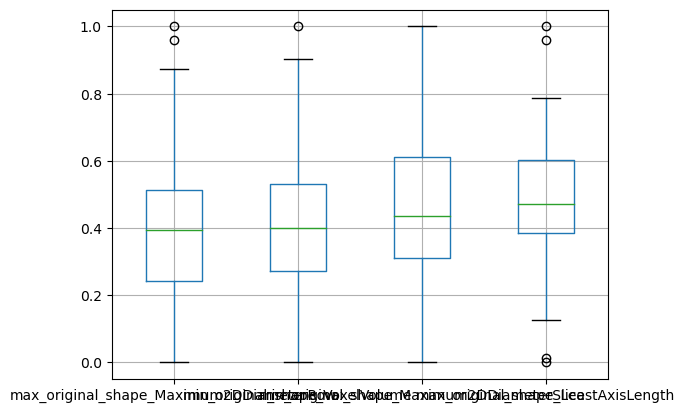

In [176]:
important_features_df_scaled.boxplot(column = list(numerical_columns)[0:4])

<AxesSubplot:>

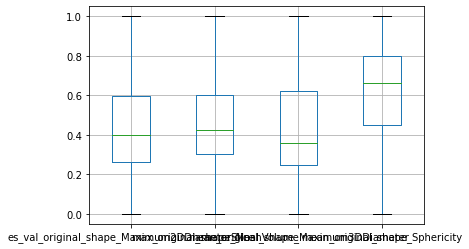

In [62]:
important_features_df_scaled.boxplot(column = list(numerical_columns)[4:8])

In [177]:
vo2_max = []
num_rows = important_features_df.shape[0]
for n in range(num_rows):
    pid = important_features_df.iloc[n]['patient_id']
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    vo2_max.append((pid,cpet_record['VO2 (MAX):'].values[0],\
                               cpet_record['dyspnea'].values[0],\
                          cpet_record['PetCO2.2'].values[0]))

In [178]:
important_features_df['pkvo2'] = [ent[1] for ent in vo2_max]
important_features_df['dyspnea'] = [ent[2] for ent in vo2_max]
important_features_df['petco2'] = [ent[3] for ent in vo2_max]

In [179]:
important_features_df.head()

,patient_id,max_original_shape_Maximum2DDiameterRow,min_original_shape_VoxelVolume,min_original_shape_Maximum2DDiameterSlice,max_original_shape_LeastAxisLength,median_original_shape_SurfaceVolumeRatio,mean_original_shape_Sphericity,median_original_shape_SurfaceArea,median_original_shape_MajorAxisLength,mean_original_shape_SurfaceArea,...,lv_es_slope,lv_std_std_distance_ratio_x,lv_std_average_radial_ratio_x,lv_std_compactness_x,lv_std_std_distance_ratio_y,lv_std_average_radial_ratio_y,lv_std_compactness_y,pkvo2,dyspnea,petco2
1,101B,93.324116,39867.9375,48.961879,47.814915,0.167855,0.656805,15414.725490,76.339074,13893.243204,...,2.006020,0.021420,0.033201,0.539633,0.013599,0.033473,0.833340,1.52,1.0,25.0
2,103,104.254796,104983.3125,53.582442,53.529400,0.116467,0.743902,19520.655020,90.643515,18523.079710,...,2.816428,0.021518,0.033120,0.285614,0.041558,0.057375,0.242789,2.36,1.0,39.0
3,105B,108.182788,123597.3750,57.835029,57.459717,0.112936,0.744217,21029.726530,96.370229,20414.987479,...,2.587199,0.015523,0.022261,0.221792,0.011419,0.021140,0.339924,2.53,1.0,30.0
4,109,101.595091,42440.0625,42.085107,47.679752,0.149964,0.720003,13287.131248,84.183141,13585.015101,...,2.048207,0.021907,0.029107,0.950794,0.020674,0.033041,0.898496,1.23,1.0,27.0
6,113B,100.141150,27142.6875,36.252802,42.053038,0.191532,0.644375,12488.727153,83.720063,11699.960350,...,1.859355,0.027851,0.069127,1.376739,0.022662,0.045689,1.464580,1.32,1.0,26.0


In [180]:
response = important_features_df['pkvo2'] 
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(important_features_df[predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],6)))
print('significant features: \n(feature name, R^2, p-value)\n')
[print(ent) for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.1];

significant features: 
(feature name, R^2, p-value)

('lvmc_vol_min', 0.279, 6.8e-05)
('min_original_shape_VoxelVolume', 0.263, 0.00012)
('lvmc_vol_ed', 0.251, 0.00018)
('median_original_shape_SurfaceVolumeRatio', 0.248, 0.000199)
('max_original_shape_MeshVolume', 0.229, 0.000382)
('mean_original_shape_LeastAxisLength', 0.218, 0.000555)
('median_original_shape_MinorAxisLength', 0.217, 0.000566)
('mean_original_shape_SurfaceArea', 0.208, 0.000769)
('median_original_shape_SurfaceArea', 0.194, 0.001209)
('ed_val_original_shape_SurfaceArea', 0.191, 0.001358)
('max_original_shape_Maximum2DDiameterColumn', 0.184, 0.001698)
('ed_val_original_shape_Maximum3DDiameter', 0.182, 0.001804)
('max_original_shape_SurfaceArea', 0.181, 0.001829)
('max_original_shape_LeastAxisLength', 0.176, 0.002172)
('mean_original_shape_Maximum3DDiameter', 0.158, 0.003835)
('median_original_shape_Maximum3DDiameter', 0.141, 0.00672)
('max_original_shape_Maximum2DDiameterRow', 0.134, 0.008314)
('es_val_original_shape_Ma

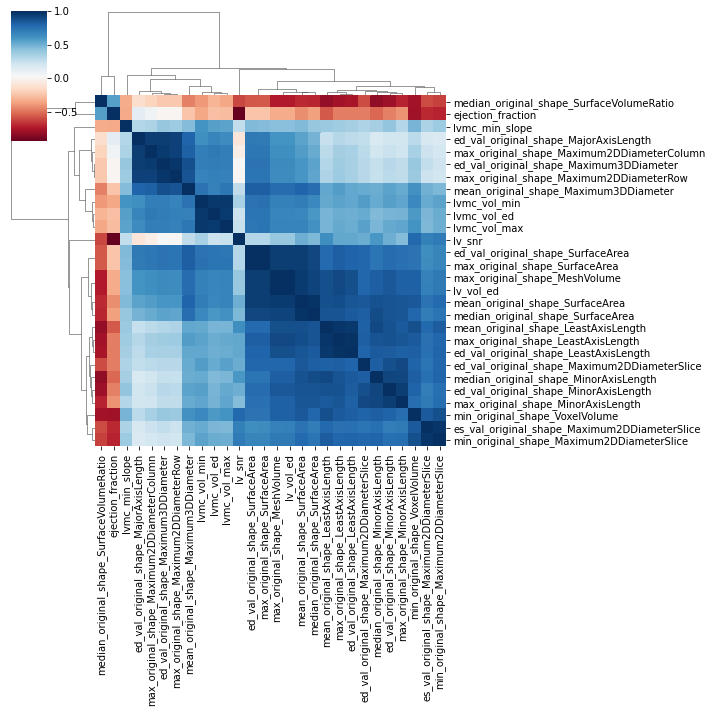

In [67]:
sns.clustermap(important_features_df[[ent[0] for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) \
                                   if ent[1] > 0.1]].corr(),cmap = 'RdBu', figsize=(10,10));

In [183]:
num_feat = 5
interesting_combos = []
for comb in itertools.combinations(numerical_columns, num_feat):
    important_features_subset = list(comb)
    if 'lvmc_vol_min' in important_features_subset and \
    'median_original_shape_SurfaceVolumeRatio' in important_features_subset:
        X = important_features_df_scaled[important_features_subset].assign(const=1)
        vif_values = [vif(X.values, i) for i in range(num_feat)]
        if max(vif_values) <= 5.:
            vif_feat_vals = {important_features_subset[ind]: vals for ind,vals in enumerate(vif_values)}
            interesting_combos.append(important_features_subset)
interesting_combos

[['max_original_shape_Maximum2DDiameterRow',
  'min_original_shape_VoxelVolume',
  'median_original_shape_SurfaceVolumeRatio',
  'mean_original_shape_Sphericity',
  'lvmc_vol_min'],
 ['max_original_shape_Maximum2DDiameterRow',
  'min_original_shape_VoxelVolume',
  'median_original_shape_SurfaceVolumeRatio',
  'median_original_shape_SurfaceArea',
  'lvmc_vol_min'],
 ['max_original_shape_Maximum2DDiameterRow',
  'min_original_shape_VoxelVolume',
  'median_original_shape_SurfaceVolumeRatio',
  'median_original_shape_MajorAxisLength',
  'lvmc_vol_min'],
 ['max_original_shape_Maximum2DDiameterRow',
  'min_original_shape_VoxelVolume',
  'median_original_shape_SurfaceVolumeRatio',
  'median_original_shape_Maximum3DDiameter',
  'lvmc_vol_min'],
 ['max_original_shape_Maximum2DDiameterRow',
  'min_original_shape_VoxelVolume',
  'median_original_shape_SurfaceVolumeRatio',
  'std_dev_original_shape_MeshVolume',
  'lvmc_vol_min'],
 ['max_original_shape_Maximum2DDiameterRow',
  'min_original_shape_V

In [184]:
len(interesting_combos)

2732

In [185]:
max_reg = 0.
multivariate_y = important_features_df[['pkvo2']]
for important_features_subset in interesting_combos:
    multivariate_x = important_features_df_scaled[important_features_subset]
    reg = LinearRegression().fit(multivariate_x, multivariate_y)
    reg_score = reg.score(multivariate_x, multivariate_y)
    if reg_score > max_reg:
        max_reg = reg_score
        max_reg_features = important_features_subset

In [187]:
print(round(max_reg,2), '\n', max_reg_features)

0.55 
 ['median_original_shape_SurfaceVolumeRatio', 'median_original_shape_MajorAxisLength', 'ed_val_original_shape_Maximum3DDiameter', 'lvmc_vol_min', 'lv_es_slope']


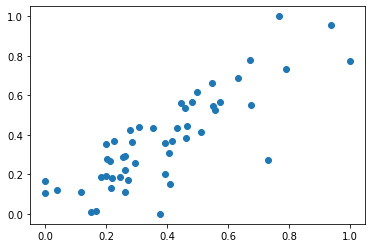

In [28]:
plt.scatter(important_features_df_scaled[max_reg_features[1]], \
            important_features_df_scaled[max_reg_features[2]])

In [188]:
X = important_features_df_scaled[max_reg_features].assign(const=1)
vif_values = [vif(X.values, i) for i in range(len(max_reg_features))]
vif_feat_vals = {max_reg_features[ind]: vals for ind,vals in enumerate(vif_values)}
vif_feat_vals = sorted(vif_feat_vals.items(), key = lambda item: item[1], reverse = True)
print('VIF values: (feature, value)\n')
[print(ent[0], round(ent[1],3)) for ent in vif_feat_vals];

VIF values: (feature, value)

ed_val_original_shape_Maximum3DDiameter 4.742
median_original_shape_MajorAxisLength 4.645
lvmc_vol_min 2.223
median_original_shape_SurfaceVolumeRatio 2.068
lv_es_slope 1.828


(0.9523576343146947, 6.3752636805962994e-27)

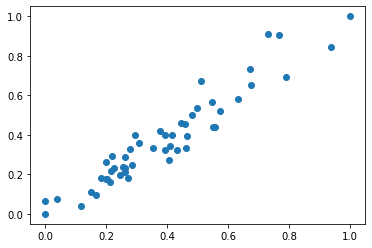

In [181]:
x,y = important_features_df_scaled['ed_val_original_shape_Maximum3DDiameter'], \
           important_features_df_scaled['ed_val_original_shape_MajorAxisLength']
plt.scatter(x,y)
pearsonr(x,y)

In [189]:
max_reg_features

['median_original_shape_SurfaceVolumeRatio',
 'median_original_shape_MajorAxisLength',
 'ed_val_original_shape_Maximum3DDiameter',
 'lvmc_vol_min',
 'lv_es_slope']

In [144]:
max_reg_features = ['median_original_shape_SurfaceVolumeRatio', 'ed_val_original_shape_Maximum3DDiameter', \
                    'median_original_shape_MajorAxisLength', 'lvmc_vol_min', 'lv_es_slope']

In [190]:
multivariate_y = important_features_df[['pkvo2']]
multivariate_x = important_features_df_scaled[max_reg_features]
data = pd.DataFrame({'x0': multivariate_x[max_reg_features[0]], \
                     'x1': multivariate_x[max_reg_features[1]], \
                     'x2': multivariate_x[max_reg_features[2]], \
                     'x3': multivariate_x[max_reg_features[3]], \
                     'x4': multivariate_x[max_reg_features[4]], \
                     'y': multivariate_y.pkvo2.values})

In [191]:
model = ols("y ~ x0 + x1 + x2 + x3 + x4", data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     11.09
Date:                Thu, 20 Oct 2022   Prob (F-statistic):           5.33e-07
Time:                        11:14:42   Log-Likelihood:                -25.270
No. Observations:                  51   AIC:                             62.54
Df Residuals:                      45   BIC:                             74.13
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7950      0.359      7.789      0.0

In [164]:
def feature_x_coefficient(ind):
    return model.params[ind+1]*multivariate_x[max_reg_features[ind]].values

In [203]:
ground_truth = multivariate_y.pkvo2.values
predicted = model.params[0] 

for i in range(5):
    predicted += feature_x_coefficient(i)

In [204]:
r = pearsonr(ground_truth, predicted)
r

(0.7737856539526938, 2.781566302174764e-11)

In [223]:
from scipy import stats

In [219]:
def confidence_interval(mean_response, ground_truth, X):
    CI_low_limit = []
    CI_upper_limit = []
    alpha = 0.05
    N = len(mean_response)
    var_n = 5
    X_sq = np.dot(X.T,X)
    X_sq_inv = np.linalg.inv(X_sq)
    mse = sum(np.array(mean_response - ground_truth)**2)/N
    
    for ind, ent in enumerate(mean_response):
        t_multiplier = stats.t.ppf(1.0 - alpha / 2.0, N - (var_n+1))
        std_error = np.sqrt(mse*(np.dot(np.dot(X[ind].T, X_sq_inv), X[ind])))
        low_limit = ent - t_multiplier*std_error
        upper_limit = ent + t_multiplier*std_error
        CI_low_limit.append(low_limit)
        CI_upper_limit.append(upper_limit)
        
    return CI_low_limit, CI_upper_limit

In [220]:
def prediction_interval(mean_response, ground_truth, X):
    PI_low_limit = []
    PI_upper_limit = []
    alpha = 0.05
    N = len(mean_response)
    var_n = 5
    X_sq = np.dot(X.T,X)
    X_sq_inv = np.linalg.inv(X_sq)
    mse = sum(np.array(mean_response - ground_truth)**2)/N
    t_multiplier = stats.t.ppf(1.0 - alpha / 2.0, N - (var_n+1))
    
    for ind, ent in enumerate(mean_response):
        std_error = mse*(np.dot(np.dot(X[ind].T, X_sq_inv), X[ind]))
        low_limit = ent - t_multiplier*np.sqrt(std_error**2 + mse)
        upper_limit = ent + t_multiplier*np.sqrt(std_error**2 + mse)
        PI_low_limit.append(low_limit)
        PI_upper_limit.append(upper_limit)
        
    return PI_low_limit, PI_upper_limit

In [402]:
CI_low_limit, CI_upper_limit = confidence_interval(predicted, ground_truth, multivariate_x.values)
PI_low_limit, PI_upper_limit = prediction_interval(predicted, ground_truth, multivariate_x.values)

In [221]:
from scipy.interpolate import UnivariateSpline

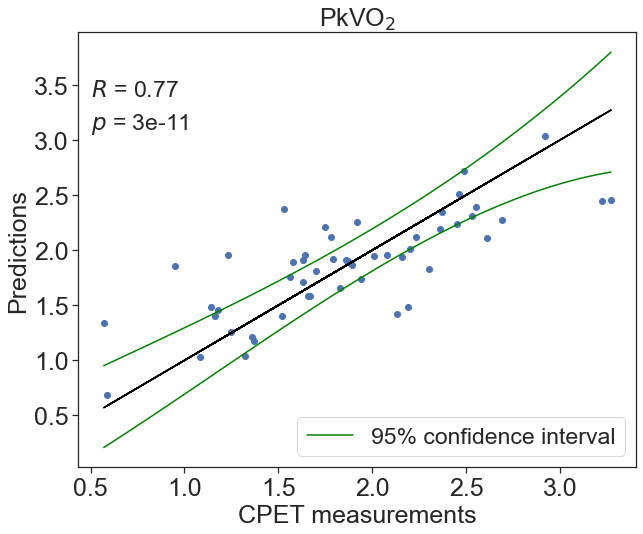

In [405]:
fontsize=25
spl_low = UnivariateSpline(sorted(predicted), sorted(CI_low_limit))
spl_upper = UnivariateSpline(sorted(predicted), sorted(CI_upper_limit))
xs = np.linspace(min(ground_truth), max(ground_truth), 100)
plt.figure(figsize=(10,8))
plt.scatter(ground_truth, predicted)
plt.plot(ground_truth, ground_truth, c='black')
plt.plot(xs, spl_low(xs),c='green',label='95% confidence interval')
plt.plot(xs, spl_upper(xs), c='green')
#plt.plot(sorted(predicted), sorted(PI_low_limit), c='red',label='95% prediction interval')
#plt.plot(sorted(predicted), sorted(PI_upper_limit), c='red')
#plt.fill_between(sort(predicted), CI_low_limit, CI_upper_limit)
#plt.scatter(ground_truth, interval2, c='black')
plt.xlabel('CPET measurements', fontsize=fontsize)
plt.ylabel('Predictions', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title('PkVO$_{2}$',fontsize=fontsize)
plt.text(0.5,3.4,f'$R$ = {round(r[0],2)}',fontsize=fontsize-2)
plt.text(0.5,3.1,f'$p$ = 3e-11',fontsize=fontsize-2)
plt.legend(loc='lower right',fontsize=fontsize-2)
plt.savefig('scatter_plot_pkvo2.png')
plt.show()

In [205]:
response = important_features_df[~important_features_df_scaled['patient_id'].isin(null_petco2_pids)]['petco2'] 
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(important_features_df[~important_features_df_scaled['patient_id'].isin(null_petco2_pids)][predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],6)))
print('significant features: \n(feature name, R^2, p-value)\n')
[print(ent) for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.1];

significant features: 
(feature name, R^2, p-value)

('max_original_shape_Maximum2DDiameterRow', 0.413, 0.0)
('ed_val_original_shape_Maximum3DDiameter', 0.383, 2e-06)
('mean_original_shape_Maximum3DDiameter', 0.343, 8e-06)
('max_original_shape_MeshVolume', 0.322, 1.7e-05)
('lv_vol_ed', 0.321, 1.8e-05)
('max_original_shape_Maximum2DDiameterColumn', 0.315, 2.2e-05)
('median_original_shape_Maximum3DDiameter', 0.312, 2.5e-05)
('ed_val_original_shape_SurfaceArea', 0.293, 4.9e-05)
('max_original_shape_SurfaceArea', 0.293, 4.9e-05)
('ed_val_original_shape_MajorAxisLength', 0.288, 6e-05)
('median_original_shape_MajorAxisLength', 0.28, 7.8e-05)
('mean_original_shape_SurfaceArea', 0.252, 0.000201)
('stroke_volume', 0.239, 0.000318)
('median_original_shape_SurfaceArea', 0.228, 0.000453)
('ed_val_original_shape_LeastAxisLength', 0.218, 0.000636)
('max_original_shape_LeastAxisLength', 0.205, 0.000955)
('mean_original_shape_LeastAxisLength', 0.201, 0.001104)
('min_original_shape_VoxelVolume', 0.184,

In [208]:
features = ['ed_val_original_shape_Maximum3DDiameter', 'max_original_shape_MeshVolume']
X = important_features_df_scaled[features].assign(const=1)
vif_values = [vif(X.values, i) for i in range(len(features))]
vif_feat_vals = {features[ind]: vals for ind,vals in enumerate(vif_values)}
vif_feat_vals = sorted(vif_feat_vals.items(), key = lambda item: item[1], reverse = True)
print('VIF values: (feature, value)\n')
[print(ent[0], round(ent[1],3)) for ent in vif_feat_vals];

VIF values: (feature, value)

ed_val_original_shape_Maximum3DDiameter 1.727
max_original_shape_MeshVolume 1.727


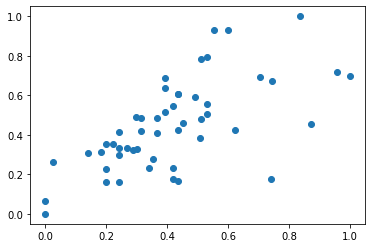

In [207]:
plt.scatter(important_features_df_scaled[features[0]], important_features_df_scaled[features[1]])

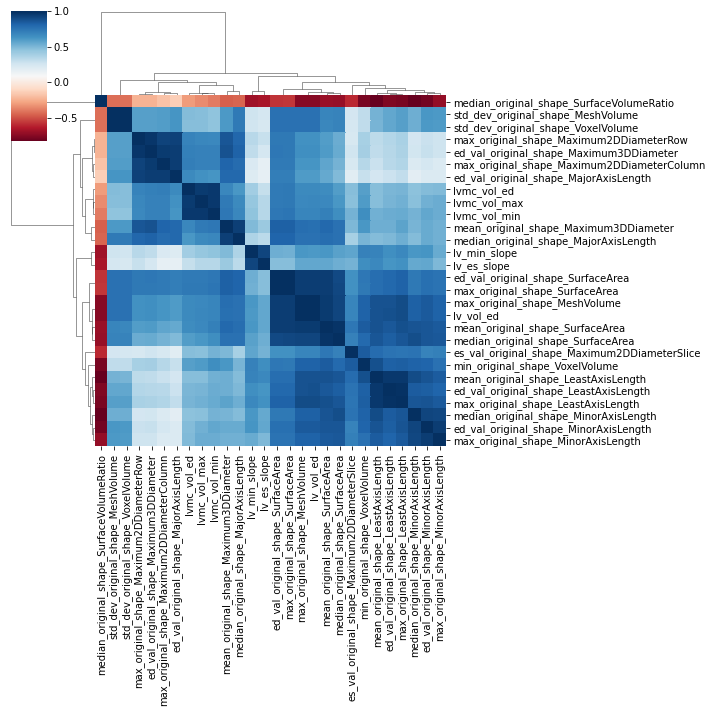

In [240]:
sns.clustermap(important_features_df[[ent[0] for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) \
                                   if ent[1] > 0.1]].corr(),cmap = 'RdBu', figsize=(10,10));

In [209]:
num_feat = 5
interesting_combos = []
for comb in itertools.combinations(numerical_columns, num_feat):
    important_features_subset = list(comb)
    if 'ed_val_original_shape_Maximum3DDiameter' in important_features_subset and \
    'max_original_shape_MeshVolume' in important_features_subset:
        X = important_features_df_scaled[important_features_subset].assign(const=1)
        vif_values = [vif(X.values, i) for i in range(num_feat)]
        if max(vif_values) <= 5.:
            vif_feat_vals = {important_features_subset[ind]: vals for ind,vals in enumerate(vif_values)}
            interesting_combos.append(important_features_subset)
interesting_combos

/Users/saurabh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


[['median_original_shape_SurfaceVolumeRatio',
  'ed_val_original_shape_Maximum3DDiameter',
  'max_original_shape_MeshVolume',
  'median_original_shape_Maximum3DDiameter',
  'lv_snr'],
 ['median_original_shape_SurfaceVolumeRatio',
  'ed_val_original_shape_Maximum3DDiameter',
  'max_original_shape_MeshVolume',
  'lv_snr',
  'lv_es_slope'],
 ['median_original_shape_SurfaceVolumeRatio',
  'ed_val_original_shape_Maximum3DDiameter',
  'max_original_shape_MeshVolume',
  'lv_snr',
  'lv_min_slope'],
 ['median_original_shape_SurfaceVolumeRatio',
  'ed_val_original_shape_Maximum3DDiameter',
  'max_original_shape_MeshVolume',
  'lv_snr',
  'lvmc_min_slope'],
 ['median_original_shape_SurfaceVolumeRatio',
  'ed_val_original_shape_Maximum3DDiameter',
  'max_original_shape_MeshVolume',
  'lv_snr',
  'lv_std_compactness_x'],
 ['median_original_shape_SurfaceVolumeRatio',
  'ed_val_original_shape_Maximum3DDiameter',
  'max_original_shape_MeshVolume',
  'lv_snr',
  'lv_std_std_distance_ratio_x'],
 ['medi

In [210]:
len(interesting_combos)

1811

In [211]:
max_reg = 0.
multivariate_y = important_features_df[~important_features_df_scaled['patient_id'].isin(null_petco2_pids)][['petco2']]
for important_features_subset in interesting_combos:
    multivariate_x = important_features_df_scaled[~important_features_df_scaled['patient_id'].isin(null_petco2_pids)][important_features_subset]
    reg = LinearRegression().fit(multivariate_x, multivariate_y)
    reg_score = reg.score(multivariate_x, multivariate_y)
    if reg_score > max_reg:
        max_reg = reg_score
        max_reg_features = important_features_subset

In [212]:
print(round(max_reg,2), '\n', max_reg_features)

0.53 
 ['median_original_shape_MajorAxisLength', 'ed_val_original_shape_Maximum3DDiameter', 'max_original_shape_MeshVolume', 'lv_std', 'lvmc_vol_ed']


In [213]:
# max_reg_features = ['es_val_original_shape_Maximum2DDiameterSlice', 'max_original_shape_MeshVolume', \
#  'mean_original_shape_Sphericity', 'max_original_shape_Maximum2DDiameterRow', 'lvmc_vol_ed']
max_reg_features = ['median_original_shape_MajorAxisLength', 'ed_val_original_shape_Maximum3DDiameter', \
 'max_original_shape_MeshVolume', 'lv_std', 'lvmc_vol_ed']

In [214]:
X = important_features_df_scaled[max_reg_features].assign(const=1)
vif_values = [vif(X.values, i) for i in range(len(max_reg_features))]
vif_feat_vals = {max_reg_features[ind]: vals for ind,vals in enumerate(vif_values)}
vif_feat_vals = sorted(vif_feat_vals.items(), key = lambda item: item[1], reverse = True)
print('VIF values: (feature, value)\n')
[print(ent[0], round(ent[1],3)) for ent in vif_feat_vals];

VIF values: (feature, value)

median_original_shape_MajorAxisLength 4.759
ed_val_original_shape_Maximum3DDiameter 4.16
max_original_shape_MeshVolume 3.259
lvmc_vol_ed 2.597
lv_std 1.364


In [215]:
multivariate_y = important_features_df[~important_features_df_scaled['patient_id'].isin(null_petco2_pids)][['petco2']]
multivariate_x = important_features_df_scaled[~important_features_df_scaled['patient_id'].isin(null_petco2_pids)][max_reg_features]
data = pd.DataFrame({'x0': multivariate_x[max_reg_features[0]], \
                     'x1': multivariate_x[max_reg_features[1]], \
                     'x2': multivariate_x[max_reg_features[2]], \
                     'x3': multivariate_x[max_reg_features[3]], \
                     'x4': multivariate_x[max_reg_features[4]], \
                     'y': multivariate_y.petco2.values})

In [216]:
model = ols("y ~ x0 + x1 + x2 + x3 + x4", data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     9.740
Date:                Mon, 26 Sep 2022   Prob (F-statistic):           2.58e-06
Time:                        10:50:24   Log-Likelihood:                -141.43
No. Observations:                  50   AIC:                             294.9
Df Residuals:                      44   BIC:                             306.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.0076      1.614     13.013      0.0

In [217]:
ground_truth = multivariate_y.petco2.values
predicted = model.params[0] 
for i in range(5):
    predicted += feature_x_coefficient(i)

In [224]:
CI_low_limit, CI_upper_limit = confidence_interval(predicted, ground_truth, multivariate_x.values)
PI_low_limit, PI_upper_limit = prediction_interval(predicted, ground_truth, multivariate_x.values)

In [225]:
r = pearsonr(ground_truth, predicted)
r

(0.7248028802164538, 2.6576850801006395e-09)

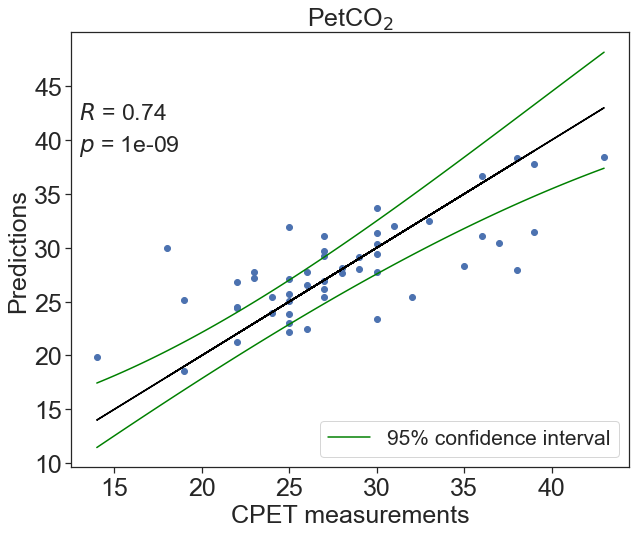

In [396]:
r = pearsonr(ground_truth, predicted)
spl_low = UnivariateSpline(sorted(predicted), sorted(CI_low_limit))
spl_upper = UnivariateSpline(sorted(predicted), sorted(CI_upper_limit))
xs = np.linspace(min(ground_truth), max(ground_truth), 100)
fontsize=25
plt.figure(figsize=(10,8))
plt.scatter(ground_truth, predicted)
plt.plot(ground_truth, ground_truth, c='black')
plt.plot(xs, spl_low(xs),c='green',label='95% confidence interval')
plt.plot(xs, spl_upper(xs), c='green')
# plt.plot(sorted(predicted), sorted(PI_low_limit), c='red',label='95% prediction interval')
# plt.plot(sorted(predicted), sorted(PI_upper_limit), c='red')
plt.xlabel('CPET measurements', fontsize=fontsize)
plt.ylabel('Predictions', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title('PetCO$_{2}$',fontsize=fontsize)
plt.text(13,42,f'$R$ = {round(r[0],2)}',fontsize=fontsize-2)
plt.text(13,39,f'$p$ = 1e-09',fontsize=fontsize-2)
plt.legend(loc='lower right',fontsize=fontsize-4)
plt.savefig('scatter_plot_petco2.png')
plt.show()

In [192]:
important_features_df.to_csv('vol_pyrads_3d_fractals_2d.csv')

### Hierarchical clustering

In [231]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from matplotlib.pyplot import figure

In [232]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, leaf_font_size = 12, leaf_rotation = 0)
    return linkage_matrix

In [233]:
important_features_subset_shortlist =['lvmc_vol_min', 'median_original_shape_SurfaceVolumeRatio',\
            'max_original_shape_Maximum2DDiameterRow', \
            'lvmc_vol_ed', 'lv_std',\
            'min_original_shape_Sphericity',
 'max_original_shape_SurfaceArea',
 'mean_original_shape_Sphericity',
 'mean_original_shape_SurfaceArea',
 'median_original_shape_Sphericity',
 'es_val_original_shape_Sphericity',
 'ed_val_original_shape_SurfaceArea',
 'lv_min_slope',
 'lvmc_min_slope']

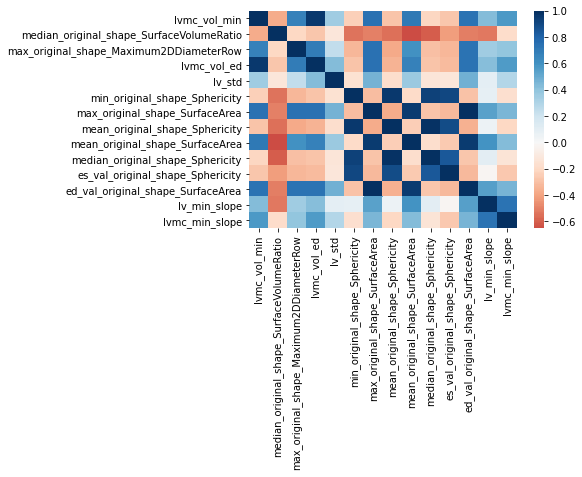

In [201]:
sns.heatmap(important_features_df[important_features_subset_shortlist].corr(),cmap = 'RdBu', center = 0.0);

In [113]:
important_features_subset_hcluster = ['lv_std', 'median_original_shape_Sphericity',\
 'median_original_shape_SurfaceVolumeRatio','lvmc_min_slope']
vif_values = [vif(important_features_df_scaled[important_features_subset_hcluster].values, i) for i in range(len(important_features_subset_hcluster))]
vif_feat_vals = {important_features_subset_hcluster[ind]: vals for ind,vals in enumerate(vif_values)}
vif_feat_vals = sorted(vif_feat_vals.items(), key = lambda item: item[1], reverse = True)
print('VIF values: (feature, value)\n')
[print(ent[0], round(ent[1],3)) for ent in vif_feat_vals];

VIF values: (feature, value)

lvmc_min_slope 4.552
lv_std 4.442
median_original_shape_Sphericity 3.326
median_original_shape_SurfaceVolumeRatio 2.132


In [117]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
multivariate_x = important_features_df_scaled[important_features_subset_hcluster]
model = model.fit(multivariate_x)

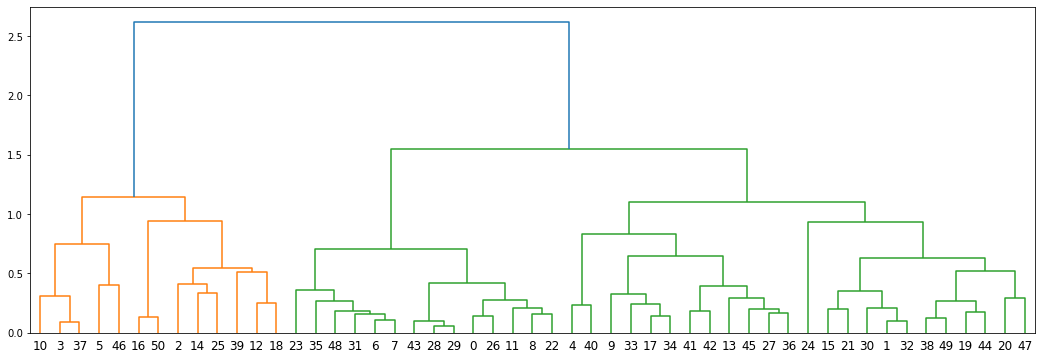

In [118]:
figure(figsize=(18, 6))
linkage_matrix = plot_dendrogram(model)

In [120]:
clustering_model = AgglomerativeClustering(n_clusters=2)
clustering_model.fit(multivariate_x)
clustering_model.labels_

array([0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1])

In [121]:
cluster_0 = [ind for ind, ent in enumerate(clustering_model.labels_) if ent == 0]
cluster_1 = [ind for ind, ent in enumerate(clustering_model.labels_) if ent == 1]
#cluster_2 = [ind for ind, ent in enumerate(clustering_model.labels_) if ent == 2]

In [122]:
df = important_features_df_scaled.reset_index(drop=True)

In [124]:
cluster_0_ids = df.loc[cluster_0].patient_id.values
cluster_1_ids = df.loc[cluster_1].patient_id.values
#cluster_2_ids = df.loc[cluster_2].patient_id.values

In [125]:
def cluster_condition(cluster):
    condition_arr = []
    for pid in cluster:
        num_pid = int(pid[0:3])
        cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
        condition = cpet_record['dyspnea']
        if condition.values[0] == 1.:
            condition_arr.append((pid,1))
        else:
            condition_arr.append((pid,0))
    return condition_arr

In [127]:
condition_arr_cluster_0 = cluster_condition(cluster_0_ids)
condition_arr_cluster_1 = cluster_condition(cluster_1_ids)
#condition_arr_cluster_2 = cluster_condition(cluster_2_ids)

In [128]:
def count_high_low_vo2(condition_arr_cluster):
    count_0 = len([ent for ent in condition_arr_cluster if ent[1] == 0])
    count_1 = len([ent for ent in condition_arr_cluster if ent[1] == 1])
    
    return count_0, count_1

In [130]:
count_0_cluster_0, count_1_cluster_0 = count_high_low_vo2(condition_arr_cluster_0)
count_0_cluster_1, count_1_cluster_1 = count_high_low_vo2(condition_arr_cluster_1)
#count_0_cluster_2, count_1_cluster_2 = count_high_low_vo2(condition_arr_cluster_2)

In [132]:
print(f'Cluster 0: 0:{count_0_cluster_0},  1:{count_1_cluster_0}')
print(f'Cluster 1: 0:{count_0_cluster_1},  1:{count_1_cluster_1}')
#print(f'Cluster 2: 0:{count_0_cluster_2},  1:{count_1_cluster_2}')

Cluster 0: 0:18,  1:20
Cluster 1: 0:1,  1:12


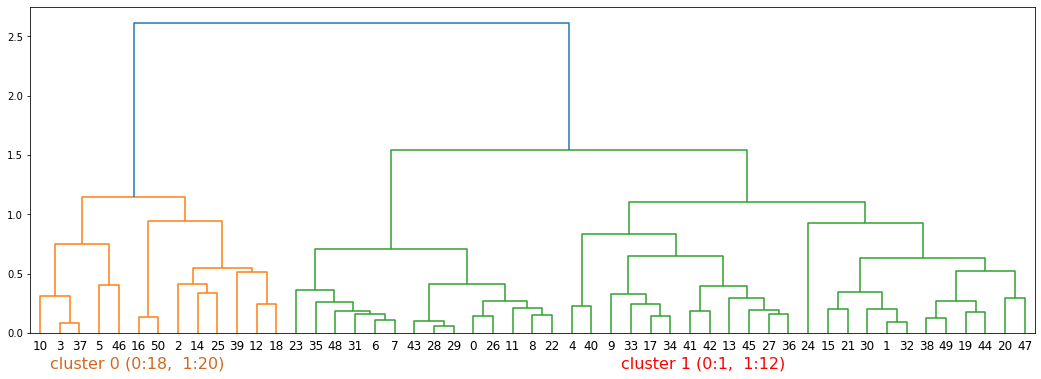

In [133]:
figure(figsize=(18, 6))
linkage_matrix = plot_dendrogram(model)
y_pos = -0.3
plt.text(300,y_pos,f'cluster 1 (0:{count_0_cluster_1},  1:{count_1_cluster_1})',size=16, c='red')
plt.text(10,y_pos,f'cluster 0 (0:{count_0_cluster_0},  1:{count_1_cluster_0})',size=16, c='chocolate');
#plt.text(130,y_pos,f'cluster 2 (0:{count_0_cluster_2},  1:{count_1_cluster_2})',size=16, c='green');

## Appendix

In [ ]:
num_rows = vol_df.shape[0]
lvef_original = []
lvef_radiomics = []

for n in range(num_rows):
    pid = vol_df.iloc[n]['patient_id']
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    if np.isnan(cpet_record['LV Ejection Fraction'].values[0]):
        pass
    else:
        lvef_original.append(cpet_record['LV Ejection Fraction'].values[0])
        lvef_radiomics.append(vol_df.iloc[n]['ejection_fraction']*100)


In [26]:
print(len(lvef_original), len(lvef_radiomics))

26 26


In [27]:
r2_score(lvef_original, lvef_radiomics)

0.035045444195593745

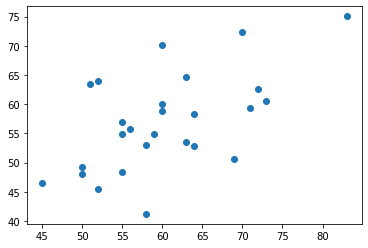

In [28]:
plt.scatter(lvef_original, lvef_radiomics)

In [98]:
import itertools

In [109]:
num_feat = 3
interesting_combos = []
for comb in itertools.combinations(numerical_columns, num_feat):
    important_features_subset = list(comb)
    vif_values = [vif(important_features_df_scaled[important_features_subset].values, i) for i in range(num_feat)]
    if max(vif_values) <= 5.:
        vif_feat_vals = {important_features_subset[ind]: vals for ind,vals in enumerate(vif_values)}
        interesting_combos.append(important_features_subset)
interesting_combos

[['mean_original_shape_LeastAxisLength',
  'median_original_shape_Sphericity',
  'median_original_shape_SurfaceVolumeRatio'],
 ['mean_original_shape_LeastAxisLength',
  'ed_val_original_shape_MajorAxisLength',
  'median_original_shape_SurfaceVolumeRatio'],
 ['mean_original_shape_LeastAxisLength',
  'ed_val_original_shape_MajorAxisLength',
  'lv_std'],
 ['mean_original_shape_LeastAxisLength',
  'median_original_shape_SurfaceVolumeRatio',
  'ed_val_original_shape_Maximum3DDiameter'],
 ['mean_original_shape_LeastAxisLength',
  'median_original_shape_SurfaceVolumeRatio',
  'es_val_original_shape_Sphericity'],
 ['mean_original_shape_LeastAxisLength',
  'median_original_shape_SurfaceVolumeRatio',
  'min_original_shape_Sphericity'],
 ['mean_original_shape_LeastAxisLength',
  'median_original_shape_SurfaceVolumeRatio',
  'max_original_shape_Maximum2DDiameterColumn'],
 ['mean_original_shape_LeastAxisLength',
  'median_original_shape_SurfaceVolumeRatio',
  'lvmc_vol_max'],
 ['mean_original_shape

In [112]:
max_score = 0.
for important_features_subset in interesting_combos:
    multivariate_x = important_features_df_scaled[important_features_subset]
    multivariate_y = important_features_df[['pkvo2']]
    reg = LinearRegression().fit(multivariate_x, multivariate_y)
    if reg.score(multivariate_x, multivariate_y) > max_score:
        max_score = reg.score(multivariate_x, multivariate_y)
        best_combo = important_features_subset
print(max_score, best_combo)

0.4129542426433277 ['median_original_shape_Sphericity', 'median_original_shape_SurfaceVolumeRatio', 'lvmc_vol_ed']


In [116]:
data = pd.DataFrame({'x0': multivariate_x[important_features_subset[0]], \
                     'x1': multivariate_x[important_features_subset[1]], \
                     'x2': multivariate_x[important_features_subset[2]], \
                     #'x3': multivariate_x[important_features_subset[3]], \
                     'y': multivariate_y.pkvo2.values})

model = ols("y ~ x0 + x1 + x2", data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     3.954
Date:                Thu, 28 Jul 2022   Prob (F-statistic):             0.0136
Time:                        15:25:47   Log-Likelihood:                -40.012
No. Observations:                  51   AIC:                             88.02
Df Residuals:                      47   BIC:                             95.75
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2038      0.288      4.180      0.0

### 2D fractals

In [381]:
fractals_2d_csv = pd.read_csv(path+'/Golnoushs_fractals/fractals_2d.csv',header=None)
fractals_2d_csv.head()

,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,76
0,PatientId,101B,101B,103,103,109,109,113B,113B,114,...,174,174,179,179,181,181,183,183,185,185
1,Phase,ed0,es4,ed0,es3,ed6,es2,ed7,es3,ed11,...,ed0,es3,ed0,es3,ed0,es3,ed0,es4,ed0,es3
2,lv_slope_1,-7.17244797022851e-07,-7.17244797022851e-07,-2.35006480096061,-2.60447083323098,-7.17244797022851e-07,-7.17244797022851e-07,-7.17244797022851e-07,-7.17244797022851e-07,-3.40636875910898e-07,...,1.62022785767115,-4.23819458745847e-07,0.277345495270733,-7.17244797022851e-07,1.6700525232077e-14,1.6700525232077e-14,-7.17244797022851e-07,-7.17244797022851e-07,-7.17244797022851e-07,-7.17244797022851e-07
3,lv_intercept_1,-13.8155093021575,-13.8155093021575,12.6947251769305,13.7171534320888,-13.8155093021575,-13.8155093021575,-13.8155093021575,-13.8155093021575,-13.8155102541196,...,-0.573086769984424,-13.8155100200713,2.89753876193571,-13.8155093021575,-13.8155105579643,-13.8155105579643,-13.8155093021575,-13.8155093021575,-13.8155093021575,-13.8155093021575
4,lv_slope_2,-6.08596281514944e-07,-6.08596281514944e-07,-2.43939199316937,-2.4479288165968,-6.08596281514944e-07,-6.08596281514944e-07,-6.08596281514944e-07,-6.08596281514944e-07,-3.35609746781348e-07,...,0.434298727343355,-1.33087932498926e-07,-0.291314529158718,-6.08596281514944e-07,2.4855571198563e-14,2.4855571198563e-14,-6.08596281514944e-07,-6.08596281514944e-07,-6.08596281514944e-07,-6.08596281514944e-07


In [382]:
fractals_2d_df = fractals_2d_csv.T
header = fractals_2d_df.iloc[0]
fractals_2d_df = fractals_2d_df[1:] #take the data less the header row
fractals_2d_df.columns = header
fractals_2d_df.head()

,PatientId,Phase,lv_slope_1,lv_intercept_1,lv_slope_2,lv_intercept_2,lv_slope_3,lv_intercept_3,lv_slope_4,lv_intercept_4,...,lvmc_slope_21,lvmc_intercept_21,lvmc_slope_22,lvmc_intercept_22,lvmc_slope_23,lvmc_intercept_23,lvmc_slope_24,lvmc_intercept_24,lvmc_avg_slope,lvmc_avg_intercept
1,101B,ed0,-7.17244797022851e-07,-13.8155093021575,-6.08596281514944e-07,-13.815509705509,-7.34981750675452e-07,-13.8155093109137,-7.61377304336471e-07,-13.8155093940655,...,-7.34981750675452e-07,-13.8155093109137,-7.61377304336471e-07,-13.8155093940655,-6.08596281514944e-07,-13.815509705509,-7.17244797022851e-07,-13.8155093021575,9.41778075697639e-06,-13.8155254939051
2,101B,es4,-7.17244797022851e-07,-13.8155093021575,-6.08596281514944e-07,-13.815509705509,-7.34981750675452e-07,-13.8155093109137,-7.61377304336471e-07,-13.8155093940655,...,-7.34981750675452e-07,-13.8155093109137,-7.61377304336471e-07,-13.8155093940655,-6.08596281514944e-07,-13.815509705509,-7.17244797022851e-07,-13.8155093021575,9.41778075697639e-06,-13.8155254939051
3,103,ed0,-2.35006480096061,12.6947251769305,-2.43939199316937,12.9484620635241,-2.19220729127321,12.4161561492411,-2.10934424464303,11.967453763633,...,-2.81107435327764,13.327957478684,-3.05523401881432,14.1246362416685,-2.93141522958304,14.0178112699712,-2.98359681478104,14.1905277669756,-3.01555112093158,13.9224312935949
4,103,es3,-2.60447083323098,13.7171534320888,-2.4479288165968,13.1313412419052,-2.38185813403835,13.1508977626358,-2.36853101956377,12.5691216719384,...,-2.86080586867664,13.0201765724558,-3.02104624435245,13.7312840087983,-3.25400883841704,14.3806431536753,-2.99251575713431,14.6044052778162,-3.02894422463501,13.8165311315163
5,109,ed6,-7.17244797022851e-07,-13.8155093021575,-6.08596281514944e-07,-13.815509705509,-7.34981750675452e-07,-13.8155093109137,-7.61377304336471e-07,-13.8155093940655,...,-7.34981750675452e-07,-13.8155093109137,-7.61377304336471e-07,-13.8155093940655,-6.08596281514944e-07,-13.815509705509,-7.17244797022851e-07,-13.8155093021575,9.41778075697639e-06,-13.8155254939051


In [383]:
fractals_2d_df_cols = fractals_2d_df.columns

for i in range(2,len(fractals_2d_df_cols)):
    fractals_2d_df[fractals_2d_df_cols[i]] = pd.to_numeric(fractals_2d_df[fractals_2d_df_cols[i]], errors='coerce')

In [384]:
num_rows = fractals_2d_df.shape[0]
for n in range(num_rows//2):
    fractals_2d_df.iat[2*n,1] = 'ed'
    
for n in range(num_rows//2):
    fractals_2d_df.iat[2*n+1,1] = 'es'

In [385]:
fractals_2d_ed = fractals_2d_df[fractals_2d_df.Phase=='ed']
fractals_2d_es = fractals_2d_df[fractals_2d_df.Phase=='es']

In [386]:
fractals_2d_ed.head()

,PatientId,Phase,lv_slope_1,lv_intercept_1,lv_slope_2,lv_intercept_2,lv_slope_3,lv_intercept_3,lv_slope_4,lv_intercept_4,...,lvmc_slope_21,lvmc_intercept_21,lvmc_slope_22,lvmc_intercept_22,lvmc_slope_23,lvmc_intercept_23,lvmc_slope_24,lvmc_intercept_24,lvmc_avg_slope,lvmc_avg_intercept
1,101B,ed,-7.172448e-07,-13.815509,-6.085963e-07,-13.815510,-7.349818e-07,-13.815509,-7.613773e-07,-13.815509,...,-7.349818e-07,-13.815509,-7.613773e-07,-13.815509,-6.085963e-07,-13.815510,-7.172448e-07,-13.815509,0.000009,-13.815525
3,103,ed,-2.350065e+00,12.694725,-2.439392e+00,12.948462,-2.192207e+00,12.416156,-2.109344e+00,11.967454,...,-2.811074e+00,13.327957,-3.055234e+00,14.124636,-2.931415e+00,14.017811,-2.983597e+00,14.190528,-3.015551,13.922431
5,109,ed,-7.172448e-07,-13.815509,-6.085963e-07,-13.815510,-7.349818e-07,-13.815509,-7.613773e-07,-13.815509,...,-7.349818e-07,-13.815509,-7.613773e-07,-13.815509,-6.085963e-07,-13.815510,-7.172448e-07,-13.815509,0.000009,-13.815525
7,113B,ed,-7.172448e-07,-13.815509,-6.085963e-07,-13.815510,-7.349818e-07,-13.815509,-7.613773e-07,-13.815509,...,-7.349818e-07,-13.815509,-7.613773e-07,-13.815509,-6.085963e-07,-13.815510,-7.172448e-07,-13.815509,0.000009,-13.815525
9,114,ed,-3.406369e-07,-13.815510,-3.356097e-07,-13.815510,-3.642006e-07,-13.815510,-4.502399e-07,-13.815510,...,-3.642006e-07,-13.815510,-4.502399e-07,-13.815510,-3.356097e-07,-13.815510,-3.406369e-07,-13.815510,0.000014,-13.815534


In [388]:
num_rows = fractals_2d_ed.shape[0]
num_cols = fractals_2d_ed.shape[1] - 2
scores = []

for c in range(2,num_cols):
    dyspnea_arr = []
    normal_arr = []

    for r in range(num_rows):
        arr = fractals_2d_ed.iloc[r][fractals_2d_ed.columns[c]]
        pid = fractals_2d_ed.iloc[r]['PatientId']
        num_pid = int(pid[0:3])
        cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
        condition = cpet_record['dyspnea']
        #print(condition.values[0])
        if condition.values[0] == 1.:
            dyspnea_arr.append(arr)
        else:
            normal_arr.append(arr)
    res = scipy.stats.mannwhitneyu(dyspnea_arr,normal_arr)
    scores.append((fractals_2d_ed.columns[c], res.pvalue))

In [389]:
significant_scores_ed = [score for score in scores if score[1] < 0.05]
significant_scores_ed = sorted(significant_scores_ed, key=lambda significant_scores_ed: significant_scores_ed[1])

In [390]:
scores = []

for c in range(2,num_cols):
    dyspnea_arr = []
    normal_arr = []

    for r in range(num_rows):
        arr = fractals_2d_es.iloc[r][fractals_2d_es.columns[c]]
        pid = fractals_2d_es.iloc[r]['PatientId']
        num_pid = int(pid[0:3])
        cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
        condition = cpet_record['dyspnea']
        #print(condition.values[0])
        if condition.values[0] == 1.:
            dyspnea_arr.append(arr)
        else:
            normal_arr.append(arr)
    res = scipy.stats.mannwhitneyu(dyspnea_arr,normal_arr)
    scores.append((fractals_2d_es.columns[c], res.pvalue))

In [391]:
significant_scores_es = [score for score in scores if score[1] < 0.05]
significant_scores_es = sorted(significant_scores_es, key=lambda significant_scores_es: significant_scores_es[1])

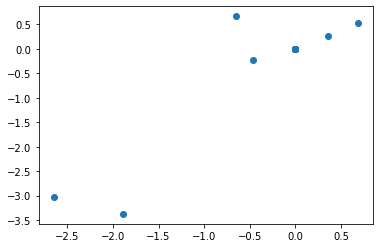

In [392]:
plt.scatter(fractals_2d_es['lv_slope_19'],fractals_2d_es['lvmc_slope_22'])

In [394]:
dyspnea_arr = []
normal_arr = []

for r in range(num_rows):
    arr = fractals_2d_es.iloc[r]['lv_slope_2']
    pid = fractals_2d_es.iloc[r]['PatientId']
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    condition = cpet_record['dyspnea']
    #print(condition.values[0])
    if condition.values[0] == 1.:
        dyspnea_arr.append(arr)
    else:
        normal_arr.append(arr)
scipy.stats.mannwhitneyu(dyspnea_arr,normal_arr)


MannwhitneyuResult(statistic=112.5, pvalue=0.024502933797889932)

In [395]:
Counter(dyspnea_arr)

Counter({-6.08596281514944e-07: 16,
         -2.4479288165968: 1,
         -3.35609746781348e-07: 1,
         -1.75320950347884: 1,
         -1.33087932498926e-07: 2,
         -0.36167615891756: 1,
         -0.33555203104179: 1,
         2.4855571198562998e-14: 1})

In [901]:
significant_features_es = [tup[0] for tup in significant_scores_es]
significant_features_ed = [tup[0] for tup in significant_scores_ed]

In [902]:
fractal_2d_es_df = fractals_2d_es[significant_features_es]
fractal_2d_ed_df = fractals_2d_ed[significant_features_ed]

In [904]:
fractal_2d_es_df.to_csv('fractal_2d_es.csv')